Case Study
---
Do you want to buy a new laptop? If yes, what is your concern?, Price, or its equipment?

Before making the decision, let us explore the price of laptop.

To make the accurate information, 
1. we will make a detailed Exploratory Data Analysis (EDA), or called data washing; 
2. create a model for prediction of the value of laptop; 
3. Deployment of the Model.


Skills of Pandas manipulation
---
1. `df['Memory].unique()`, set of terms in this feature; 特徵項目
2. `df['Memory].value_counts()`, count of each unique term in this feature; 特徵項目數量
3. `df["Memory"].str.split(pat=pattern,expand=True)`, split string into different features, by using `pattern` as the delimiter string. 依照特徵分解特徵值
4.  `df['Price'].apply(lambda x:np.log1p(x))`, evaluate the feature by `log(1+x)`, i.e. the quantity of exponential term since it might be in too large scale, 取對數，log(1+x), 因為數量級太大所以取指數的量 
5.  Extract the part of digits, where  
```
# more than one digit, 包含至少一個數字
pattern='(\d+)'
df['Memory'].str.extract(pattern,expand=True)
```
5. Extract the part of letters, 包含至少一個英文字母
```
# more than one letter, capital or not
pattern='([A-Za-z+]+)'
df['Memory'].str.extract(pattern,expand=True)
```

Save Model
---
After model created, trained, save the model as follows for next time to utilize again:
```python
final_cat = finalize_model(cat_model)
save_model(final_cat, 'deloyment_xxx')
```  

In [1]:
#git+ssh://git@raw.githubusercontent.com/{user}/{repo}/
#!pip uninstall -y tw_matplotlib
!pip install git+https://github.com/cchuang2009/tw_matplotlib.git
#!pip install git+ssh://git@raw.githubusercontent.com/cchuang2009/tw_matplotlib/
import tw_matplotlib

In [59]:
!pip install -U  category_encoders --ignore-installed --no-deps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached category_encoders-2.5.1.post0-py2.py3-none-any.whl (72 kB)


### ❖ EDA
---
Most features in DataFrame are in type of timestamp, numeric, or object. Before survey data, visualizing features suitably is wise choice. 大部分的特徵，通常被歸為時間，數值，或者物件累.適當的 將他們視覺化，有助於了解. 
1. Classify the features

```python
def viz_features(df_):
     # classify features in numeric or categorical
     num_feature = [ x in df_.columns if df[x].dtype !=' object']
     obj_feature = [ x in df_.columns if df[x].dtype ==' object']
     # histogram if categorical, otherwise pie
     for i in df_:    
         if i in num_feature:
            plt.subplots()
            plt.title(i)
            plt.hist(df_[i])
         elif i in obj_feature:
            plt.subplots(figsize=(15,7))
            plt.title(i)
            plt .pie(df_[i].value_counts(), 
              labels = df_[i].value_counts().index, autopct = '%.2f%%')
``` 
2. missing value Treatment
```python
import statistics as stat
df.isnull().sum()
for i in df.columns:
    if i in null_cols and df[i].dtype != object:
        df[i]= df[i].fillna(df[i].mean())
    else:
        df[i]= df[i].fillna(stat.mode(df[i]))
df.isnull().sum()
```
3. Label Encoding
```python
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
encoder = LabelEncoder()
for i in df:
    if i in obj_feature:
        df[i+'_encoded'] = encoder.fit_transform(df[i])
        df.drop(i, axis=1, inplace=True)
```
4. Feature Scaling
After encoding categorical features, transform all the features to same scaling:
```python
scaler =MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df.to_numpy()), columns= df.columns)
```
5. Feature Reduction
```python
plt.figure(figsize=(15,8), facecolor='linen')
sns.heatmap(df.corr(), annot=True)
plt.title('HEATMAP FOR DATASET', fontweight='bold', size=20)
```


In [60]:
# Caused by conflit with another packages, re-install matplotlib

!pip uninstall -y matplotlib
!pip install matplotlib==3.2.2

Found existing installation: matplotlib 3.2.2
Uninstalling matplotlib-3.2.2:
  Successfully uninstalled matplotlib-3.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.2.2-cp37-cp37m-manylinux1_x86_64.whl (12.4 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycaret 3.0.0rc4 requires kaleido>=0.2.1, which is not installed.
pycaret 3.0.0rc4 requires plotly-resampler>=0.7.2.2, which is not installed.
pycaret 3.0.0rc4 requires pmdarima!=1.8.1,<2.0.0,>=1.8.0, which is not installed.
pycaret 3.0.0rc4 requires pyod>=0.9.8, which is not installed.
pycaret 3.0.0rc4 requires schemdraw>=0.14, which is not installed.
pycaret 3.0.0rc4 requires tbats>=1.1.0, which is not installed.
pycaret 3.0.0rc4 requires lightgbm>=3.0.0, but you have lightgbm 2.2.3 which is incompatible.
pycaret 3.0.0rc4 

In [ ]:
# update the package to make the visualisation work in colab
# 如果不肯定 Google drive 是否能夠印出來，可以先行在執行程式之前，更新 matplotlib 

!pip install -U  seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd 
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import tw_matplotlib
# pkg for interactive vis

# for categorical_encoder
import category_encoders as ce

import warnings
warnings.filterwarnings('ignore')
#把warning省略掉

%matplotlib inline

Using lux
---
Lux helps pandas DataFrame to visualize output automatically and efficiently. Lux 用視覺化的方式，幫忙找出數據之間的關係

```
[installation and Usage]
# installation 安裝方式
!pip install lux-api

# use on Google drive, 在 Google Drive 上面使用
from google.colab import output
output.enable_custom_widget_manager()


import lux
df = ...
df
# click [Toggle Pandas/Lux] to work, 啟動

# or use by chosen target, "Price",依照某個參數觀察
df.intent = ["Price"]
df
```

In [3]:
# Data, 資料來源
file="https://raw.githubusercontent.com/Raghavagr/Laptop_Price_Prediction/main/laptop_data.csv"
#file="Laptop_prive.csv"

df = pd.read_csv(file,index_col=0) 

In [ ]:
# save the data without index, 如果要存檔

df.to_csv("Laptop_prive.csv",index=0)

In [ ]:
df.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


Value of Laptop, 手提電腦的價值
---
Value of laptop is certainly included the following equipments, 手提電腦的價值包含下列設備:
```
Company
TypeName
Inches
ScreenResolution
CPU
GPU
Memory
OP sys
Ram
```
To predict the value, we have to get out the "RIGHT" information of data by EDA. 利用 EDA 取出正確的資料來估計價值

Exploratory Data Analysis, EDA
---

### 1. Ram, Weight

In [4]:
# delete the useless feature, 消除沒用的欄位，

#df.drop(columns=['Unnamed: 0'],inplace=True)

## remove gb and kg from Ram and weight and convert the cols to numeric, 除掉去除單位，留下數目字

df['Ram'] = df['Ram'].str.replace("GB", "")
df['Weight'] = df['Weight'].str.replace("kg", "")
df['Ram'] = df['Ram'].astype('int32')
df['Weight'] = df['Weight'].astype('float32')

# Transform unit of price and make it in hundreds, 轉換價值單位，並最小為 00 計價  
df['Price'] = ((0.39*df['Price']//100)*100).astype('int')

In [10]:
# ❖
def viz_features(df_):
     num_feature = [ x for x in df_.columns if df[x].dtype !='object']
     obj_feature = [ x for x in df_.columns if df[x].dtype =='object']

     for f_ in df_.columns:    
         if f_ in num_feature:
            plt.subplots()
            plt.title(f_+" 長條圖")
            plt.hist(df_[f_])
         elif f_ in obj_feature:
            plt.subplots(figsize=(15,7))
            plt.title(f_+" 圓餅圖長條")
            plt.pie(df_[f_].value_counts(), 
              labels = df_[f_].value_counts().index, autopct = '%.2f%%')

In [5]:
def feature_histogram_vis(df,col):
    plt.figure(figsize=(12,8))
    plt.title(col+" 長條圖")
    sns.set_style('darkgrid')
    sns.countplot(data=df,x=col)
    plt.xticks(rotation="vertical");
    plt.show()

In [8]:
def feature_pie_vis(df,col):
    df_=df[[col]].copy()
    if len(df_[col].value_counts())>9:

       ind_=list(df_[col].value_counts()[:9].index)
       val_0=list(df_[col].value_counts()[:9].values)
       val_1=df_[col].value_counts()[9:].sum()
       ind_.append('Others')
       val_0.append(val_1)
    #
       explode=[0.1,0,0,0,0,0,0,0,0,0]
    else:
       ind_=list(df_[col].value_counts().index)
       val_0=list(df_[col].value_counts().values)
       explode=[0]*len(val_0)
       explode[0]=0.1  

    fig, ax = plt.subplots(figsize=(15,7))
    plt.title(col+" 圓餅圖")
    
    ax.pie(val_0, labels=ind_, autopct='%.2f%%', shadow=True, explode=explode,
            startangle=90)
    ax.axis('equal') 


In [9]:
def viz_features_v2(df_):
     num_feature = [ x for x in df_.columns if df[x].dtype !='object']
     obj_feature = [ x for x in df_.columns if df[x].dtype =='object']
     explode=[0.1,0,0,0,0,0,0,0,0,0]
     for f_ in df_.columns:    
         if f_ in num_feature:
            #plt.subplots()
            #plt.title(f_+" 長條圖")
            #plt.hist(df_[f_])
            feature_histogram_vis(df_,f_)
         elif f_ in obj_feature:
            feature_pie_vis(df_,f_)

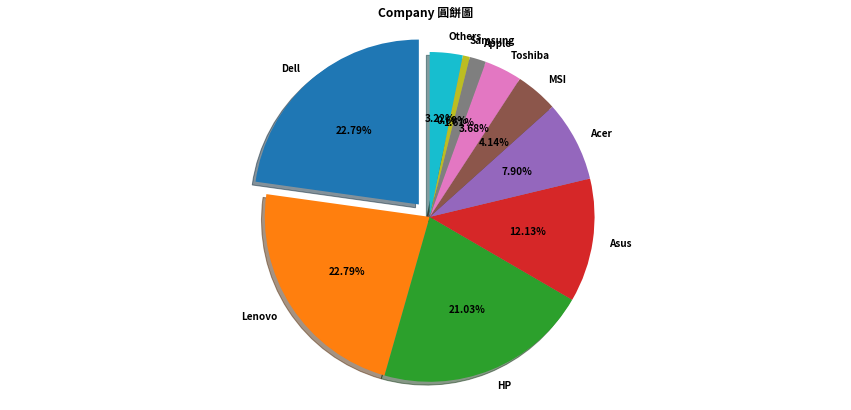

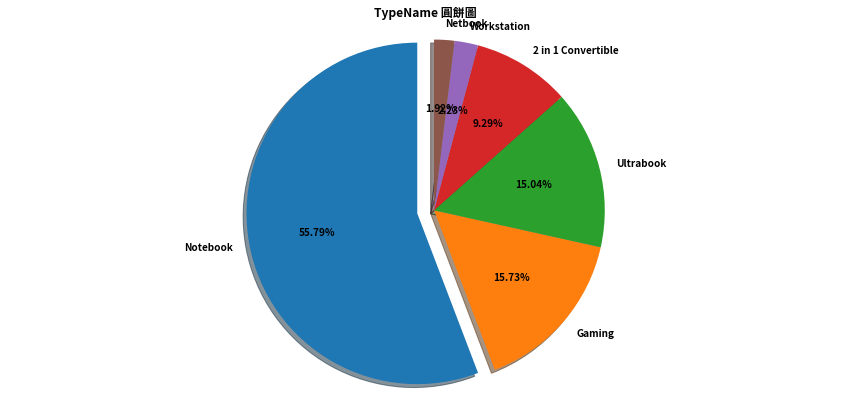

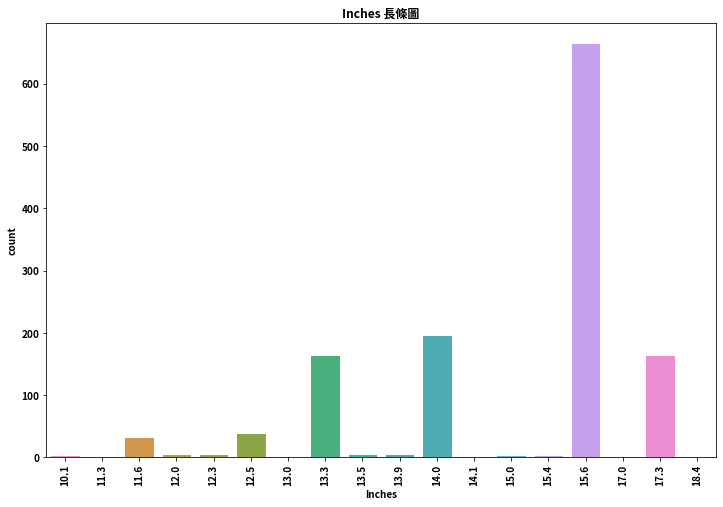

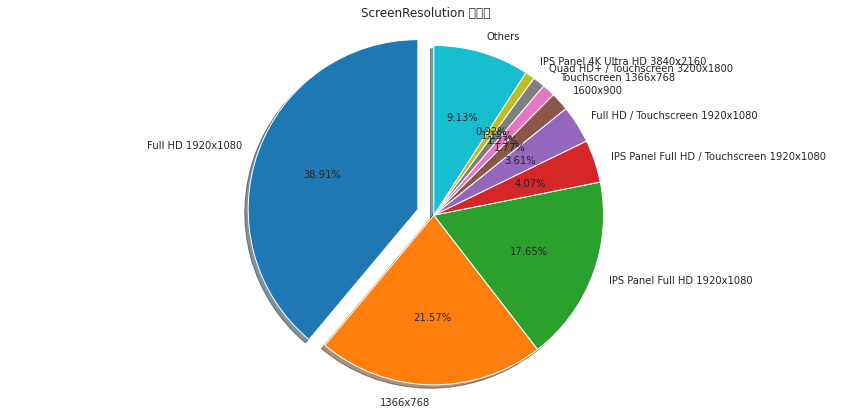

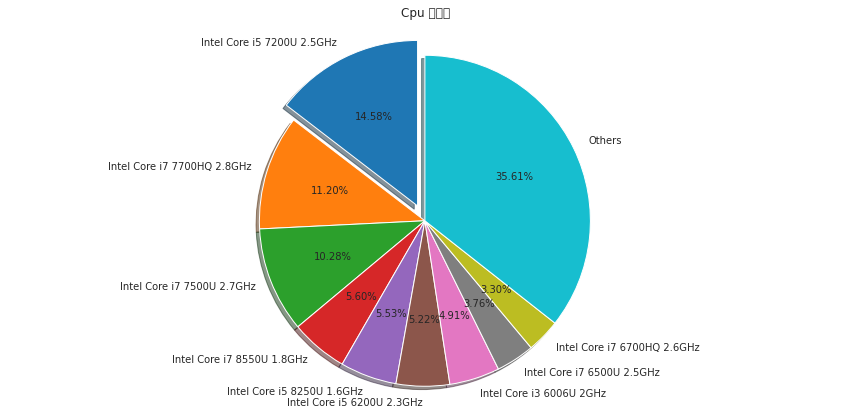

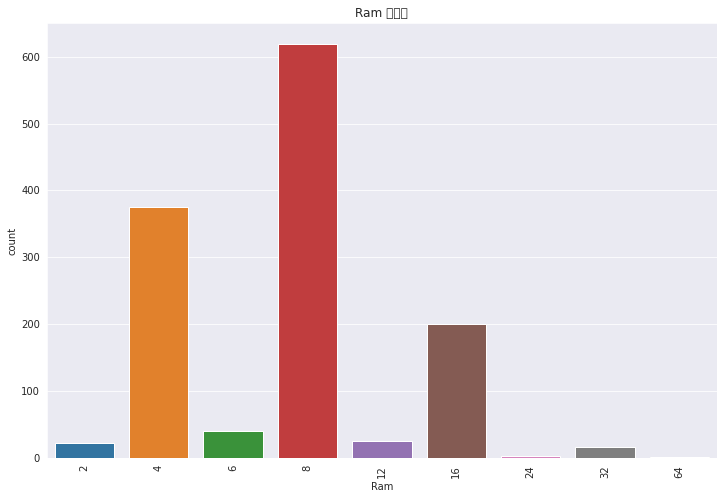

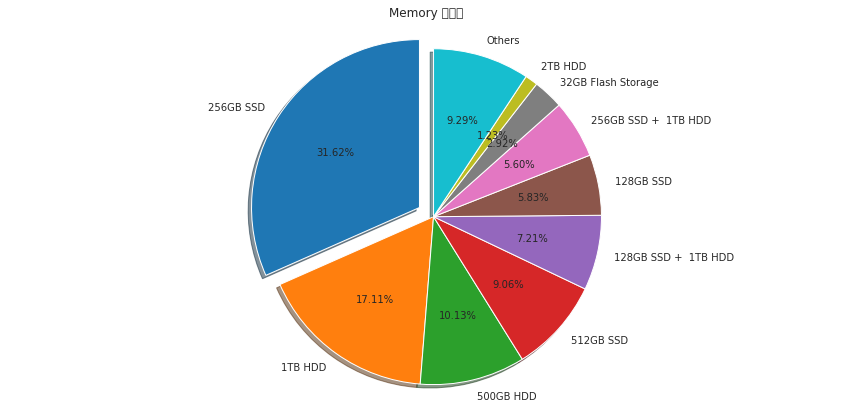

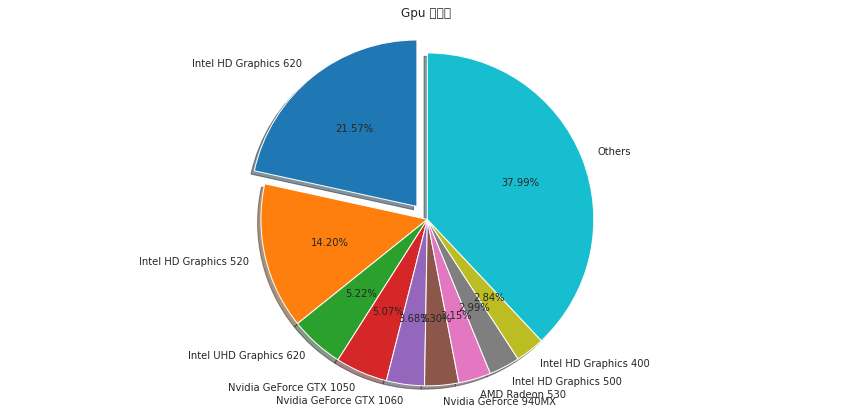

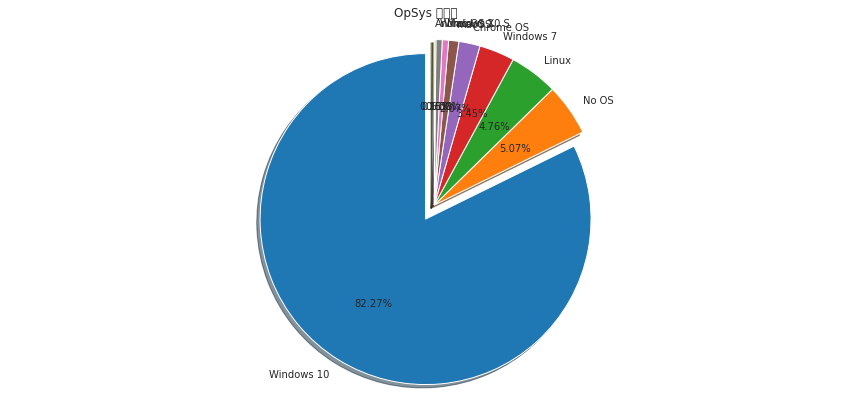

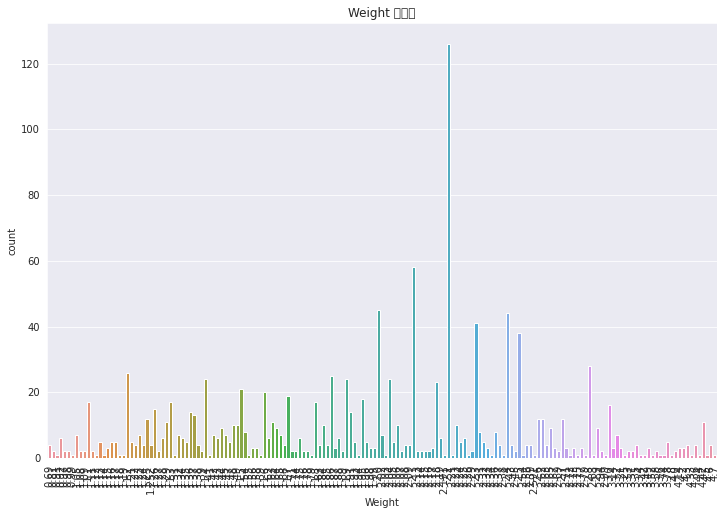

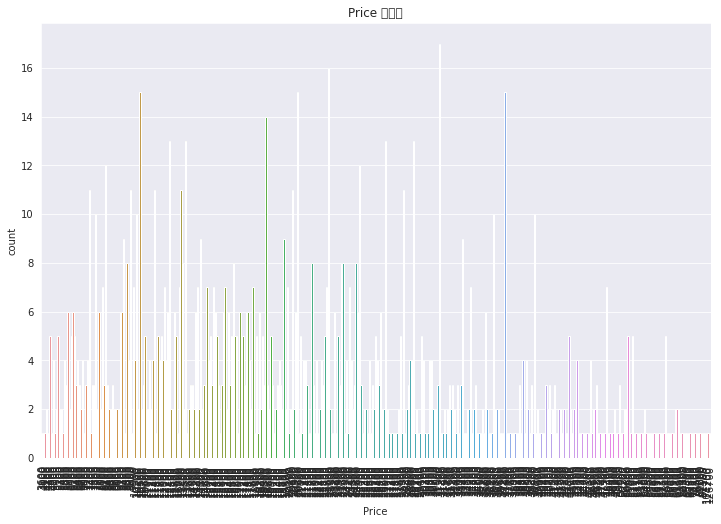

In [10]:
# ❖
viz_features_v2(df)

### 2. CPU and GPU
---
Only companies and running velocity to be extracted, 使用哪一家的中央處理器，和執行速度
1. companies: Intel ( `core i*` or `not`) , AMD, others
2. velocity: `%d.%d`GHz

#### Steps
---
1. Classify what kind of CPU, 中央處理器的品牌: 
    - Intel:  a) `core-i` series or b) `not Intel core-i`, 
    - `AMD`
    - and `others`

```
# split by space, get the first 3 words, e.g. Intel Core i7, 取出前面三個資料

" ".join(x.split()[0:3])
```
2. velocity of CPU, extract the string `*.*` from `*.*GHz` and convert it to float, 取出執行速度，去掉單位並轉為小數:
```
# define the pattern, at least one digit after . and before GHz
pattern='([.\d]+GHz)'
df['CPU_vel']=(df['Cpu'].str.extract(pattern,expand=True))
# convert to float
df['CPU_vel']=df['Cpu'].apply(lambda x: str(x)[:-3]).astype(float)
```

3. Company of GPU, Intel, Nvidia, AMD or other, 圖形處理器的品牌:
```
pattern=' '
df['GPU']=df['Gpu'].str.split(pat=pattern,expand=True)[0]
```

In [ ]:
# CPU data, 有哪些型態的中央處理器，下列則找出處理器的執行速度

np.sort(df['Cpu'].unique())

array(['AMD A10-Series 9600P 2.4GHz', 'AMD A10-Series 9620P 2.5GHz',
       'AMD A10-Series A10-9620P 2.5GHz', 'AMD A12-Series 9700P 2.5GHz',
       'AMD A12-Series 9720P 2.7GHz', 'AMD A12-Series 9720P 3.6GHz',
       'AMD A4-Series 7210 2.2GHz', 'AMD A6-Series 7310 2GHz',
       'AMD A6-Series 9220 2.5GHz', 'AMD A6-Series 9220 2.9GHz',
       'AMD A6-Series A6-9220 2.5GHz', 'AMD A8-Series 7410 2.2GHz',
       'AMD A9-Series 9410 2.9GHz', 'AMD A9-Series 9420 2.9GHz',
       'AMD A9-Series 9420 3GHz', 'AMD A9-Series A9-9420 3GHz',
       'AMD E-Series 6110 1.5GHz', 'AMD E-Series 7110 1.8GHz',
       'AMD E-Series 9000 2.2GHz', 'AMD E-Series 9000e 1.5GHz',
       'AMD E-Series E2-6110 1.5GHz', 'AMD E-Series E2-9000 2.2GHz',
       'AMD E-Series E2-9000e 1.5GHz', 'AMD FX 8800P 2.1GHz',
       'AMD FX 9830P 3GHz', 'AMD Ryzen 1600 3.2GHz',
       'AMD Ryzen 1700 3GHz', 'Intel Atom X5-Z8350 1.44GHz',
       'Intel Atom Z8350 1.92GHz', 'Intel Atom x5-Z8300 1.44GHz',
       'Intel Atom x5-Z835

In [ ]:
np.sort(df['Gpu'].unique())

array(['AMD FirePro W4190M', 'AMD FirePro W4190M ', 'AMD FirePro W5130M',
       'AMD FirePro W6150M', 'AMD R17M-M1-70', 'AMD R4 Graphics',
       'AMD Radeon 520', 'AMD Radeon 530', 'AMD Radeon 540',
       'AMD Radeon Pro 455', 'AMD Radeon Pro 555', 'AMD Radeon Pro 560',
       'AMD Radeon R2', 'AMD Radeon R2 Graphics', 'AMD Radeon R3',
       'AMD Radeon R4', 'AMD Radeon R4 Graphics', 'AMD Radeon R5',
       'AMD Radeon R5 430', 'AMD Radeon R5 520', 'AMD Radeon R5 M315',
       'AMD Radeon R5 M330', 'AMD Radeon R5 M420', 'AMD Radeon R5 M420X',
       'AMD Radeon R5 M430', 'AMD Radeon R7', 'AMD Radeon R7 Graphics',
       'AMD Radeon R7 M360', 'AMD Radeon R7 M365X', 'AMD Radeon R7 M440',
       'AMD Radeon R7 M445', 'AMD Radeon R7 M460', 'AMD Radeon R7 M465',
       'AMD Radeon R9 M385', 'AMD Radeon RX 540', 'AMD Radeon RX 550',
       'AMD Radeon RX 560', 'AMD Radeon RX 580', 'ARM Mali T860 MP4',
       'Intel Graphics 620', 'Intel HD Graphics', 'Intel HD Graphics 400',
       'Inte

### CPU

[Cpu] ➜ ['CPU_vel', 'Cpu_brand']

新增兩個特徵, ['CPU_vel', 'Cpu_brand']

In [11]:
#first we will extract Name of CPU which is first 3 words from Cpu column and then we will check which processor it is
def fetch_processor(x):
  cpu_name = " ".join(x.split()[0:3])
  if cpu_name == 'Intel Core i7' or cpu_name == 'Intel Core i5' or cpu_name == 'Intel Core i3' or cpu_name[:2] =='Intel Xeon' :
    return cpu_name
  elif cpu_name.split()[0] == 'Intel':
    return 'Other Intel Processor'
  elif cpu_name.split()[0] == 'AMD':
    return cpu_name    
  else:
    return 'Others Processor'

def EDA_CPU(df_,f_='Cpu'):
    # has one digit or none before GHz, GHz 之前有一個或沒有小數點
    pattern='([.\d]+GHz)'
    df_['CPU_vel']=(df_[f_].str.extract(pattern,expand=True))
    # keep the info before GHz, 保留 GHz 之前的資料
    df_['CPU_vel']=df_['CPU_vel'].apply(lambda x: str(x)[:-3]).astype(float)
    return df_

df['Cpu_brand'] = df['Cpu'].apply(lambda x: fetch_processor(x))
df=EDA_CPU(df)


In [12]:
df[['Cpu','Cpu_brand','CPU_vel']].head()

,Cpu,Cpu_brand,CPU_vel
0,Intel Core i5 2.3GHz,Intel Core i5,2.3
1,Intel Core i5 1.8GHz,Intel Core i5,1.8
2,Intel Core i5 7200U 2.5GHz,Intel Core i5,2.5
3,Intel Core i7 2.7GHz,Intel Core i7,2.7
4,Intel Core i5 3.1GHz,Intel Core i5,3.1


In [ ]:
df_1=df.copy()

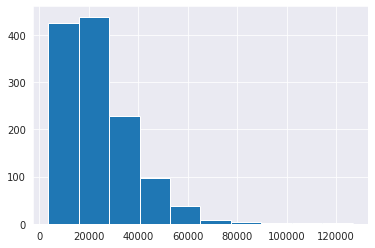

In [ ]:
df_1[df_1['Cpu'].str.contains("Intel")]['Price'].hist()

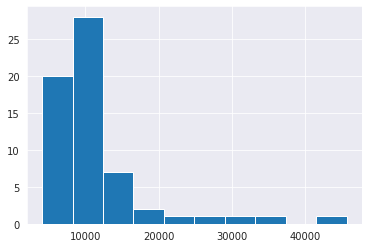

In [ ]:
df_1[df_1['Cpu'].str.contains("AMD")]['Price'].hist()

In [ ]:
df_1[df_1['Gpu'].str.contains("Intel")]['Price'].hist()

NameError: ignored

Note
---
Most of devices are equipped with `Intel`-cloned CPU; this could be ignored the others. 

#### GPU

extract kind of GPU, ['GPU']

找出圖形處理器的品牌，新增 ['GPU']

In [13]:
def EDA_GPU(df_,f_='Gpu'):
    pattern=' '
    df_['GPU']=df_[f_].str.split(pat=pattern,expand=True)[0]
    return df_

df=EDA_GPU(df)

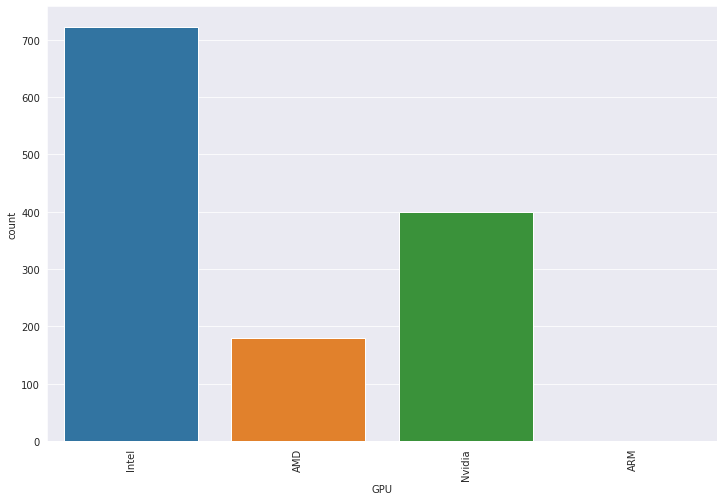

In [ ]:
feature_vis(df,'GPU')

2. Second case:
```
features=['Ram','Weight','Cpu','Cpu_brand','CPU_vel','Gpu','GPU']
target='Price']
```

<Figure size 864x576 with 0 Axes>

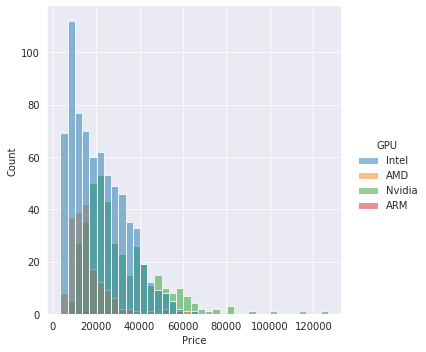

In [ ]:
plt.figure(figsize=[12,8])
sns.displot(data=df,x='Price',hue='GPU')
#sns.displot(data=penguins, x="flipper_length_mm", hue="species", multiple="stack")



<Figure size 864x576 with 0 Axes>

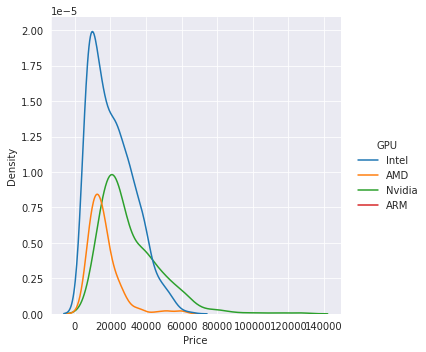

In [ ]:
plt.figure(figsize=[12,8])
sns.displot(data=df,x="Price",kind="kde",hue="GPU")


### 3. EDA of Memory
---
This feature contains the specification of storage, which is highly related the selling price of device. The format
of feature includes the following, 硬碟配備數目和容量大小:

1. `digit(s) letters`, 硬碟容量大小 硬碟種類: 
```
digits: size of memory, null, 2, 8, 16 ...,
letters: type of storages, SSD, Flash Storage, HDD, Hybrid
```
2.` * + *`: more than two kinds of storages equipment, 兩個硬碟使用 "+" 隔開:
```
256(512) SSD + 256 SSD, 256 SSD + HDD, 64 Flash Storage + HDD, 256(512) SSD + Hybrid, HDD + HDD
```

And the important factors are:
1. kind of storage, `HDD, SSD, Flash Storage`, 硬碟種類，其他;
2. number of storages: 1, or 2 (hybrid, or cell, containing `+`)，一個或兩個硬碟
3. size of each storage:, 1, 2, 16, 64, 256, 512，硬碟容量;
4. others (?)，其他

#### Skills of Pandas manipulation
---
1. `df['Memory'].unique()`, set of terms in this feature;
2. `df['Memory'].value_counts()`, count of each unique term in this feature;
3. `df["Memory"].str.split(pat=pattern,expand=True)`, split string into different features, by using `pattern` as the delimiter string.
4.  Extract the part of digits, where  
```
# more than one digit
pattern='(\d+)'
df['Memory'].str.extract(pattern,expand=True)
```
5. Extract the part of letters, 
```
# more than one letter, capital or not
pattern='([A-Za-z+]+)'
df['Memory'].str.extract(pattern,expand=True)
```

#### Steps
---
Every set has storage no more than two.  最多只有兩個硬碟
1. split to `first` or `second`，分開不同的硬碟裝置.
2. In each part of `1.`, extract `size` and `type`，分別取出容量大小和型態
3. four new features created，共有四個新特徵產生:
```
fist_size, first_type,  second_size, second_type
``` 

In [ ]:
df['Memory'].unique()

array(['128GB SSD', '128GB Flash Storage', '256GB SSD', '512GB SSD',
       '500GB HDD', '256GB Flash Storage', '1TB HDD',
       '32GB Flash Storage', '128GB SSD +  1TB HDD',
       '256GB SSD +  256GB SSD', '64GB Flash Storage',
       '256GB SSD +  1TB HDD', '256GB SSD +  2TB HDD', '32GB SSD',
       '2TB HDD', '64GB SSD', '1.0TB Hybrid', '512GB SSD +  1TB HDD',
       '1TB SSD', '256GB SSD +  500GB HDD', '128GB SSD +  2TB HDD',
       '512GB SSD +  512GB SSD', '16GB SSD', '16GB Flash Storage',
       '512GB SSD +  256GB SSD', '512GB SSD +  2TB HDD',
       '64GB Flash Storage +  1TB HDD', '180GB SSD', '1TB HDD +  1TB HDD',
       '32GB HDD', '1TB SSD +  1TB HDD', '512GB Flash Storage',
       '128GB HDD', '240GB SSD', '8GB SSD', '508GB Hybrid', '1.0TB HDD',
       '512GB SSD +  1.0TB Hybrid', '256GB SSD +  1.0TB Hybrid'],
      dtype=object)

### Memory, Storage
[Memory] ➜ ['first_size','second_size','first_type','second_type']

In [14]:
def EDA_Memory(df_,f_='Memory'):
    # split storage(s)
    # remove GB unit
    # convert TB to 1000
    # remove .0
    df1=df_.copy()
    df1[f_] = df1[f_].astype(str).replace('.0', '', regex=True)
    df1[f_] = df1[f_].str.replace('GB', '')
    df1[f_] = df1[f_].str.replace('TB', '000')
    
    # determine whether therr are two units of stoages or not
    pattern="+"
    devices = (df1[f_].str.split(pat=pattern,expand=True))
    
    # the first device
    pat1=" "
    dev0 = (devices[0].str.split(pat=pat1,expand=True))
    
    # size of storage
    pattern_1='(\d+)'
    s1=list(devices[0].str.extract(pattern_1,expand=True)[0])
    s2=list(devices[1].str.extract(pattern_1,expand=True)[0])
    # type of storage
    pattern_2='([A-Za-z+]+)'
    t1=list(devices[0].str.extract(pattern_2,expand=True)[0])
    t2=list(devices[1].str.extract(pattern_2,expand=True)[0])
    # Create features of storages
    df1['first_size']=s1
    df1['first_type']=t1
    df1['second_size']=s2
    df1['second_type']=t2
    df1['first_size'].fillna(0,inplace=True)
    df1['second_size'].fillna(0,inplace=True)
    df1['second_type'].fillna(0,inplace=True)
    df1['first_size']=df1['first_size'].astype(int)
    df1['second_size']=df1['second_size'].astype(int)
    
    # convert 0 to None id noe seconf storage, 如果沒有第二個硬碟，改為 None
    df1.loc[df1['second_type'] == 0, 'second_type'] ='None'
    
    return df1

In [15]:
#df1=df[['Memory']].copy()
df=EDA_Memory(df,f_='Memory')


In [ ]:
df['first_type'].unique()

array(['SSD', 'Flash', 'HDD', 'Hybrid'], dtype=object)

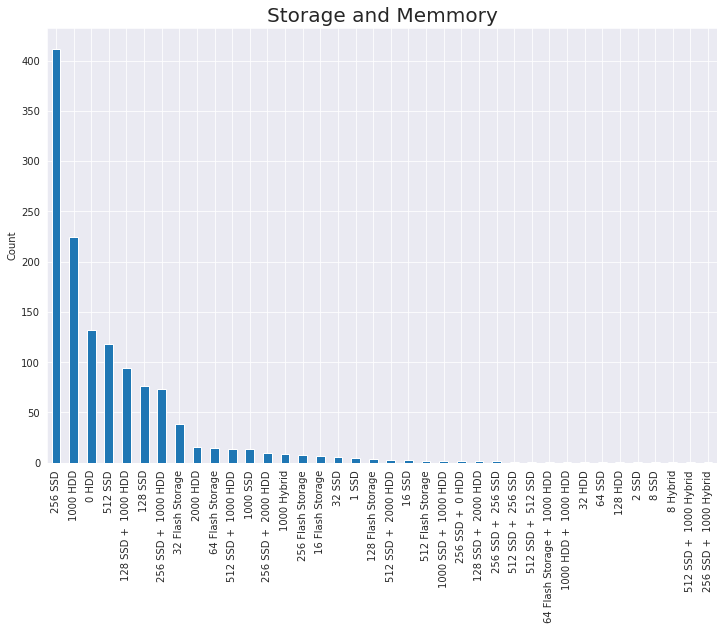

In [ ]:
plt.figure(figsize=(12,8))
plt.title("Storage and Memmory",size=20)
df['Memory'].value_counts().plot(kind='bar',ylabel='Count');

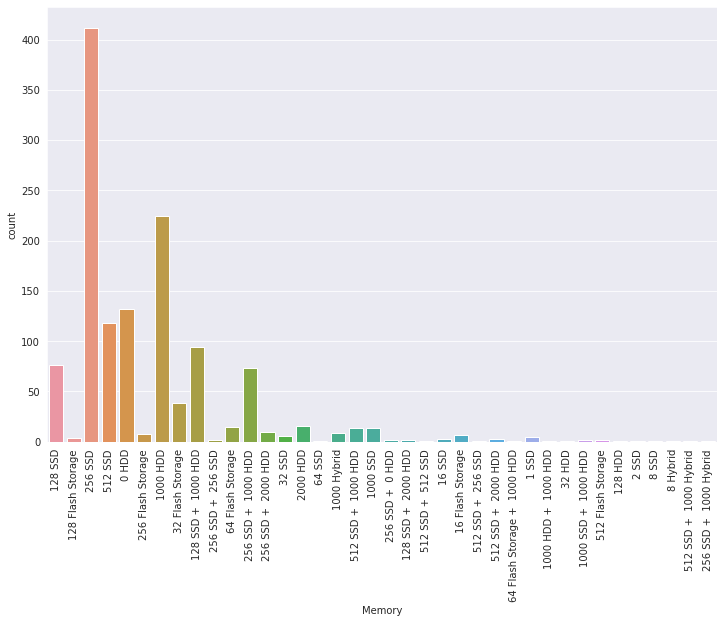

In [ ]:
plt.figure(figsize=(12,8))

sns.set_style('darkgrid')
sns.countplot(data=df,x='Memory')
plt.xticks(rotation="vertical");

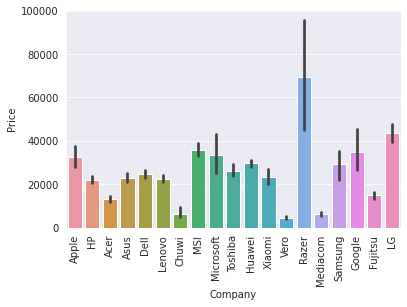

In [ ]:
#what is avg price of each brand?

sns.barplot(x=df['Company'], y=df['Price'])

plt.xticks(rotation="vertical");

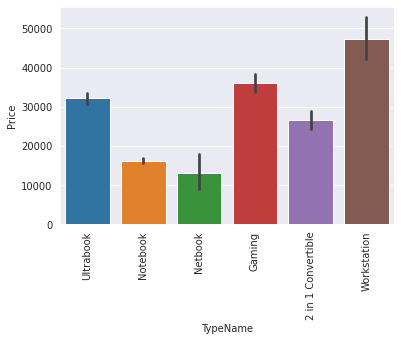

In [ ]:
#data['TypeName'].value_counts().plot(kind='bar')
sns.barplot(x=df['TypeName'], y=df['Price'])
plt.xticks(rotation="vertical");

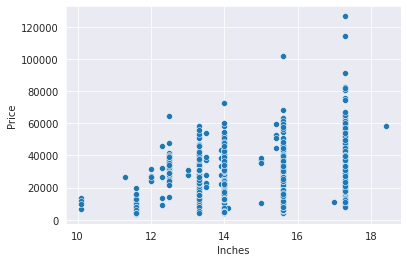

In [ ]:
sns.scatterplot(x=df['Inches'],y=df['Price'])


### 4. Touchscreen
Whether is touchscreen, create new feature ['Touchscreen'] 

是否會觸控面板，新增特徵 ['Touchscreen'] 

In [16]:
# whether is Touchscreen or not, 是否為觸控面板
df['Touchscreen'] = df['ScreenResolution'].apply(lambda x:1 if 'Touchscreen' in x else 0)


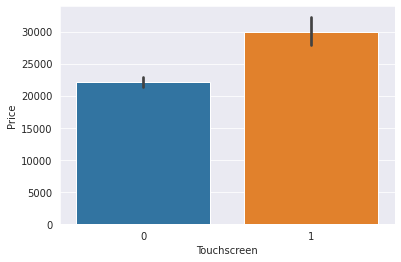

In [17]:
#how many laptops in data are touchscreen
sns.countplot(df['Touchscreen'])
#Plot against price
sns.barplot(x=df['Touchscreen'],y=df['Price'])

### 5. Ips
Whether is lps, add ['Ips']

是否為硬板，新增特徵['Ips']

In [18]:
# whether  IPS is, 是否為硬版 
df['Ips'] = df['ScreenResolution'].apply(lambda x:1 if 'IPS' in x else 0)


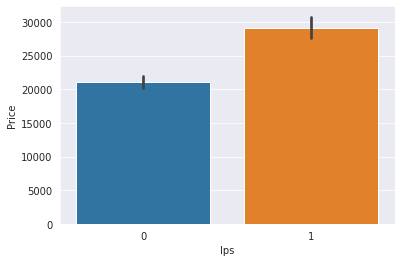

In [ ]:
sns.barplot(x=df['Ips'],y=df['Price'])

### 6. Resolution

['X_res','Y_res'] ➜ ['ppi']
$$\text{ ppi } = \frac{\sqrt{X_{res}^2+Y_{res}^2}}{\text{Inches}}$$

解析度，特徵值可以為 ['X_res','Y_res', 'ppi']

In [19]:
# X-Y resolution, X, Y 解析度
def findXresolution(s):
  return s.split()[-1].split("x")[0]
def findYresolution(s):
  return s.split()[-1].split("x")[1]
#finding the x_res and y_res from screen resolution
df['X_res'] = df['ScreenResolution'].apply(lambda x: findXresolution(x))
df['Y_res'] = df['ScreenResolution'].apply(lambda y: findYresolution(y))
#convert to numeric
df['X_res'] = df['X_res'].astype('int')
df['Y_res'] = df['Y_res'].astype('int')

In [20]:
# Pixel per inches(PPI), having a strong correlatsolution, ion, PPI 解析度
df['ppi'] = (((df['X_res']**2) + (df['Y_res']**2))**0.5/df['Inches']).astype('float')


In [21]:
df.corr()['Price'].sort_values(ascending=False)

Price          1.000000
Ram            0.742876
X_res          0.556480
Y_res          0.552757
ppi            0.473446
CPU_vel        0.430313
second_size    0.293982
Ips            0.252150
Weight         0.210373
Touchscreen    0.191211
Inches         0.068191
first_size    -0.021216
Name: Price, dtype: float64

In [ ]:
#df.drop(columns = ['ScreenResolution', 'Inches','X_res','Y_res'], inplace=True)


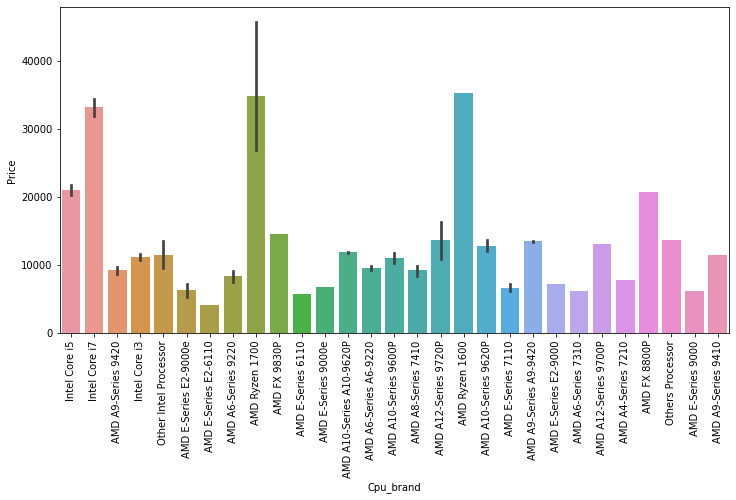

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x=df['Cpu_brand'],y=df['Price'])
plt.xticks(rotation='vertical');

In [ ]:
sns.barplot(df['Ram'], df['Price'])

In [ ]:
df.head()

### 7. Opration Systen

Operation system, create ['os']

['OpSys'] ➜ ['os'] 

新增作業系統特徵 ['os']

In [22]:
# Get which OP sys, 作業系統資料
def cat_os(inp):
    if inp == 'Windows 10' or inp == 'Windows 7' or inp == 'Windows 10 S':
        return 'Windows'
    elif inp == 'macOS' or inp == 'Mac OS X':
        return 'Mac'
    else:
        return 'Others/No OS/Linux'
df['os'] = df['OpSys'].apply(cat_os)
#data.drop(columns=['OpSys'],inplace=True)

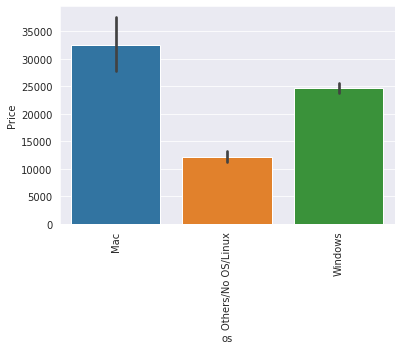

In [ ]:
sns.barplot(x=df['os'],y=df['Price'])
plt.xticks(rotation='vertical');


In [ ]:
# skew solved
sns.distplot(np.log(data['Price']));

In [ ]:
def sns_hist_and_bar(df, col, bins=10, figsize=(10, 5)):
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    sns.histplot(df[col], bins=bins, ax=ax[0])
    sns.barplot(x=df[col].value_counts().index, y=df[col].value_counts(), ax=ax[1])
    plt.show()

# Prediction by Pycaret

In [23]:
!pip install --pre --no-deps pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.2/487.2 kB 10.0 MB/s eta 0:00:00


In [24]:
!pip install sktime category_encoders scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 31.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycaret 3.0.0rc4 requires kaleido>=0.2.1, which is not installed.
pycaret 3.0.0rc4 requires plotly-resampler>=0.7.2.2, which is not installed.
pycaret 3.0.0rc4 requires pmdarima!=1.8.1,<2.0.0,>=1.8.0, which is not installed.
pycaret 3.0.0rc4 requires pyod>=0.9.8, which is not installed.
pycaret 3.0.0rc4 requires schemdraw>=0.14, which is not installed.
pycaret 3.0.0rc4 requires tbats>=1.1.0, which is not installed.
pycaret 3.0.0rc4 requires lightgbm>=3.0.0, but you have lightgbm 2.2.3 which is incompatible.
pycaret 3.0.0rc4 requires matplotlib>=3.3.0, but you have matplotlib 3.2.2 which is incompatible.
pycaret 3.0.0rc4 requires numba~=0.5

In [25]:
# install additional packages for model building

!pip install -U xgboost catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.9/255.9 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.7 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [23]:
df.columns

Index(['Company', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu', 'Ram',
       'Memory', 'Gpu', 'OpSys', 'Weight', 'Price', 'Cpu_brand', 'CPU_vel',
       'GPU', 'first_size', 'first_type', 'second_size', 'second_type',
       'Touchscreen', 'Ips', 'X_res', 'Y_res', 'ppi', 'os'],
      dtype='object')

In [24]:
# numberical feature, 數字化資料
num_features=['Inches','Ram','CPU_vel','Touchscreen', 'Ips', 'X_res', 'Y_res', 'ppi','first_size', 'second_size','Weight']
# catigorical data，種類資料
cat_features=['Company', 'TypeName','Cpu_brand', 'GPU', 'first_type', 'second_type','os']
# target 目標參數
target=['Price']

In [41]:
cat_features

['Company', 'TypeName', 'Cpu_brand', 'GPU', 'first_type', 'second_type', 'os']

In [42]:
#Could automatically filtered out the features into different format: numerical or categorical?

# get object feat
cat_features_all = df.select_dtypes(include=['object']).columns.to_list()
num_features=df.select_dtypes(include=['int','float']).columns.to_list()
num_features= [item for item in num_features if item !='Price']
target =['Price']

In [ ]:
df['Price1']=df['Price'].apply(lambda x:np.log(x))

In [ ]:
df[['Price','Price1']].head()

In [25]:
from pycaret.regression import *

In [26]:
data=df[num_features+cat_features+target].copy()

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303 entries, 0 to 1302
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Inches       1303 non-null   float64
 1   Ram          1303 non-null   int32  
 2   CPU_vel      1303 non-null   float64
 3   Touchscreen  1303 non-null   int64  
 4   Ips          1303 non-null   int64  
 5   X_res        1303 non-null   int64  
 6   Y_res        1303 non-null   int64  
 7   ppi          1303 non-null   float64
 8   first_size   1303 non-null   int64  
 9   second_size  1303 non-null   int64  
 10  Weight       1303 non-null   float32
 11  Company      1303 non-null   object 
 12  TypeName     1303 non-null   object 
 13  Cpu_brand    1303 non-null   object 
 14  GPU          1303 non-null   object 
 15  first_type   1303 non-null   object 
 16  second_type  1303 non-null   object 
 17  os           1303 non-null   object 
 18  Price        1303 non-null   int64  
dtypes: flo

In [27]:
reg1 = setup(data = data, target = 'Price')

,Description,Value
0,Session id,5348
1,Target,Price
2,Target type,Regression
3,Data shape,"(1303, 29)"
4,Train data shape,"(912, 29)"
5,Test data shape,"(391, 29)"
6,Numeric features,11
7,Categorical features,7
8,Preprocess,True
9,Imputation type,simple


In [47]:
# setup pycaret regression model, 設定 Pycaret 回歸模型
features_=['Inches', 'Ram', 'CPU_vel', 'Touchscreen', 'Ips', 'X_res', 'Y_res',
       'ppi', 'first_size', 'second_size', 'Weight', 'Company', 'TypeName',
       'Cpu_brand', 'GPU', 'first_type', 'second_type', 'os', 'Price']
reg1 = setup(data = data, target = 'Price')

,Description,Value
0,Session id,8450
1,Target,Price
2,Target type,Regression
3,Data shape,"(1303, 29)"
4,Train data shape,"(912, 29)"
5,Test data shape,"(391, 29)"
6,Numeric features,10
7,Categorical features,7
8,Preprocess,True
9,Imputation type,simple


In [ ]:
# types of models availed, 提供的模型
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [28]:
# Compare models, 各種模型的比較
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,5311.0385,58225629.6698,7577.7802,0.7165,0.3359,0.2634,0.1060
lr,Linear Regression,5327.7497,58803686.4709,7617.4576,0.7142,0.3434,0.2642,1.0310
lasso,Lasso Regression,5327.0698,58793920.5238,7616.3288,0.7142,0.3418,0.2642,0.2340
llar,Lasso Least Angle Regression,5330.3445,59040073.5351,7626.8423,0.7142,0.3392,0.2626,0.1130
en,Elastic Net,5386.4094,60455830.0966,7716.4445,0.7067,0.3112,0.2665,0.1240
et,Extra Trees Regressor,5955.4411,74909768.8971,8504.1793,0.6492,0.3330,0.3099,0.4490
catboost,CatBoost Regressor,6210.9826,81708980.5728,8907.7949,0.6171,0.3554,0.3285,2.4870
knn,K Neighbors Regressor,5765.0865,87253763.1151,9064.6515,0.6064,0.3241,0.2592,0.1560
gbr,Gradient Boosting Regressor,6135.6513,85568763.4938,9099.1611,0.5996,0.3585,0.3243,0.2340
omp,Orthogonal Matching Pursuit,6411.9518,83022612.9569,9015.2853,0.5981,0.3820,0.3425,0.1100


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Ridge(random_state=5348)

Note
---
1. There are more than 20 models testd, awesome.
2. How many model do you know? `lr` mesns `linear regression` only, right? But it is not the best one of tested models, from the measures:
   - MAE, Mean Absolute Error
$$\text{ MAE } = \frac{1}{n}\sum_i|y_i-\hat y_i|$$   
   - MSE, Mean Square Error
$$\text{ MSE } = \frac{1}{n}\sum_i(y_i-\hat y_i)^2$$ 
3. Here suggests the best one is `catboost`, a tree-based regression.

In [29]:
lr = create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5634.1221,81269096.3630,9014.9374,0.7374,0.2920,0.2494
1,5755.4569,59986364.7449,7745.0865,0.7637,0.3102,0.2686
2,4392.2896,37033437.1339,6085.5104,0.7876,0.3570,0.2695
3,6043.8346,72623683.6984,8521.9530,0.6787,0.3727,0.2776
4,4847.8758,39344075.3797,6272.4856,0.7114,0.3325,0.2550
5,6026.1095,58631791.1456,7657.1399,0.6394,0.3349,0.2947
6,5271.1742,50221209.9664,7086.6925,0.6823,0.3027,0.2661
7,4936.0943,69602516.6700,8342.8123,0.6194,0.3057,0.2308
8,4511.9295,58891206.8902,7674.0607,0.7558,0.3494,0.2349


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [30]:
pred_lr = predict_model(lr)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,5527.4945,60924310.0094,7805.4026,0.7046,0.3240,0.2474


In [31]:
pred_lr.columns

Index(['Inches', 'Ram', 'CPU_vel', 'Touchscreen', 'Ips', 'X_res', 'Y_res',
       'ppi', 'first_size', 'second_size', 'Weight', 'Company', 'TypeName',
       'Cpu_brand', 'GPU_Intel', 'GPU_Nvidia', 'GPU_AMD', 'GPU_ARM',
       'first_type_SSD', 'first_type_Flash', 'first_type_HDD',
       'first_type_Hybrid', 'second_type_None', 'second_type_HDD',
       'second_type_SSD', 'os_Windows', 'os_Mac', 'os_Others/No OS/Linux',
       'Price', 'prediction_label'],
      dtype='object')

In [32]:
data.columns

Index(['Inches', 'Ram', 'CPU_vel', 'Touchscreen', 'Ips', 'X_res', 'Y_res',
       'ppi', 'first_size', 'second_size', 'Weight', 'Company', 'TypeName',
       'Cpu_brand', 'GPU', 'first_type', 'second_type', 'os', 'Price'],
      dtype='object')

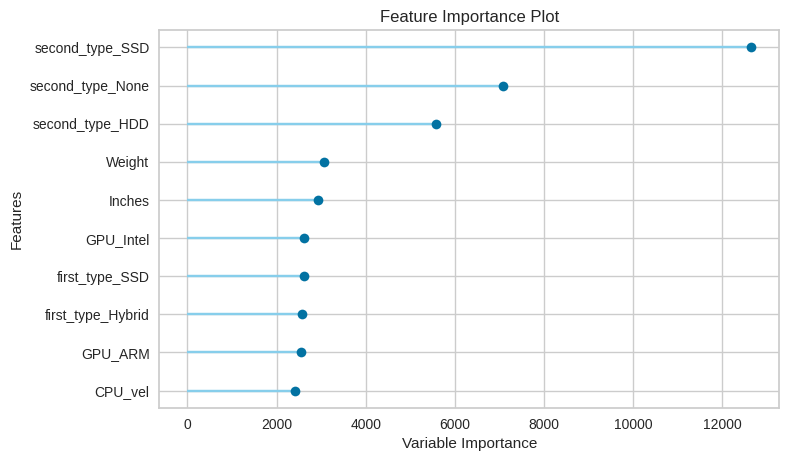

In [33]:
# Plot of Feature Importance
plot_model(lr, plot='feature')

In [ ]:
lr.feature_names_in_

array(['Inches', 'Ram', 'CPU_vel', 'Touchscreen', 'Ips', 'X_res', 'Y_res',
       'ppi', 'first_size', 'second_size', 'Weight', 'Company',
       'TypeName', 'Cpu_brand', 'GPU_Intel', 'GPU_AMD', 'GPU_Nvidia',
       'first_type_SSD', 'first_type_HDD', 'first_type_Flash',
       'first_type_Hybrid', 'second_type_None', 'second_type_HDD',
       'second_type_SSD', 'second_type_Hybrid', 'os_Windows',
       'os_Others/No OS/Linux', 'os_Mac'], dtype=object)

In [ ]:
lr.coef_

array([-7.46559958e+02,  1.06087897e+03,  2.92614025e+03, -5.81835770e+02,
       -2.98640059e+02,  7.64855157e+00, -3.45141565e+00,  6.52207569e+00,
       -1.22960559e+00, -1.12568237e+00,  3.66054088e+03,  3.50197215e-01,
        3.45981429e-01,  1.72406092e-01,  2.34590832e+03, -1.68867973e+03,
       -6.57228589e+02,  3.29271441e+03, -3.67640030e+02,  2.00936069e+02,
       -3.12601045e+03,  2.99174886e+02, -3.09631291e+03, -8.71050087e+03,
        1.15076389e+04,  7.71538054e+02, -2.68142865e+03,  1.90989059e+03])

In [34]:
# print out the LRmodel,  線性回歸模型

print("Liner regression model:\nPrice = ")
for i in range(len(lr.feature_names_in_)):
      print('\t',lr.coef_[i]," ∘ ",lr.feature_names_in_[i])

Liner regression model:
Price = 
	 -2934.6599561317107  ∘  Inches
	 1174.5372246231893  ∘  Ram
	 2420.167994760346  ∘  CPU_vel
	 -1086.4316936247967  ∘  Touchscreen
	 -124.70660853518224  ∘  Ips
	 15.175871475614858  ∘  X_res
	 14.852897436866673  ∘  Y_res
	 -212.1469197134585  ∘  ppi
	 -1.471509761191901  ∘  first_size
	 -2.1250204061095657  ∘  second_size
	 3056.329672662807  ∘  Weight
	 0.24756812882279866  ∘  Company
	 0.37255731679368886  ∘  TypeName
	 0.13712287483038835  ∘  Cpu_brand
	 2626.5852565334944  ∘  GPU_Intel
	 232.31057269266773  ∘  GPU_Nvidia
	 -319.7634254618654  ∘  GPU_AMD
	 -2539.1324037683366  ∘  GPU_ARM
	 2610.150871608059  ∘  first_type_SSD
	 -500.39438335880993  ∘  first_type_Flash
	 462.25110374743537  ∘  first_type_HDD
	 -2572.0075919947785  ∘  first_type_Hybrid
	 7080.5326009663595  ∘  second_type_None
	 5571.0516620718345  ∘  second_type_HDD
	 -12651.584263040422  ∘  second_type_SSD
	 1144.9214118043258  ∘  os_Windows
	 1156.1680846351599  ∘  os_Mac
	 -2301

In [35]:
final_lr = finalize_model(lr)
save_model(final_lr, '2022_11_17_deloyment_lr')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Inches', 'Ram', 'CPU_vel',
                                              'Touchscreen', 'Ips', 'X_res',
                                              'Y_res', 'ppi', 'first_size',
                                              'second_size', 'Weight'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['Company', 'TypeName', 'Cpu_brand',
                                              'GPU', 'first_type', 'second_type...
                                                               use_cat_names=True))),
                 ('rest_encoding',
                  TransformerWrapper(include=['Company', 'TypeName',
                                              'Cpu_brand'],
                                     transformer=LeaveOneOutEncoder(cols=['Company',
      

In [40]:
lr_=load_model("2022_11_17_deloyment_lr")
lr_

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=Memory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['Inches', 'Ram', 'CPU_vel',
                                             'Touchscreen', 'Ips', 'X_res',
                                             'Y_res', 'ppi', 'first_size',
                                             'second_size', 'Weight'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['Company', 'TypeName', 'Cpu_brand',
                                             'GPU', 'first_type', 'second_type...
                                                              use_cat_names=True))),
                ('rest_encoding',
                 TransformerWrapper(include=['Company', 'TypeName',
                                             'Cpu_brand'],
                                    transformer=LeaveOneOutEncoder(cols=['Company',
                     

Note
---
The quantities of  features ranges very large, from 10000 to 1. This makes the model unstable. And this comes from the fact of Pycaret auto-encoding on the categorical features. 從模型中，可以發覺到每個特徵值的係數範圍非常大，因此會造成模型的不穩定性，而這個原因是因為 pycaret 自動幫我們型態特徵編碼的關係. 

To reduce the un-stability, we can encode the categorical features before pycaret's work, 為了解決這個問題，我們可以在送到 pycaret 之前先行將這些型態特徵編碼。

In [ ]:
cat_features

['Company', 'TypeName', 'Cpu_brand', 'GPU', 'first_type', 'second_type', 'os']

In [ ]:
# encoding manually, 編碼
from sklearn.preprocessing import LabelEncoder
def encoding(feature):
    df[feature+'_name_encoded'] = LabelEncoder().fit_transform(df[feature])
    
#cat_features=['Company','TypeName','OpSys','Cpu_brand']
for f_ in cat_features:
    encoding(f_)

In [ ]:
cat_features=['Company_name_encoded', 'TypeName_name_encoded',
       'Cpu_brand_name_encoded', 'GPU_name_encoded','first_type_name_encoded',
       'second_type_name_encoded','os_name_encoded']

In [ ]:
df[cat_features].head()

In [ ]:
df.columns

Index(['Company', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu', 'Ram',
       'Memory', 'Gpu', 'OpSys', 'Weight', 'Price', 'Cpu_brand', 'CPU_vel',
       'GPU', 'first_size', 'first_type', 'second_size', 'second_type',
       'Touchscreen', 'Ips', 'X_res', 'Y_res', 'ppi', 'os',
       'Company_name_encoded', 'TypeName_name_encoded',
       'Cpu_brand_name_encoded', 'GPU_name_encoded', 'first_type_name_encoded',
       'second_type_name_encoded', 'os_name_encoded'],
      dtype='object')

In [ ]:
num_features+cat_features

['Inches',
 'Ram',
 'CPU_vel',
 'Touchscreen',
 'Ips',
 'X_res',
 'Y_res',
 'ppi',
 'first_size',
 'second_size',
 'Weight',
 'Company_name_encoded',
 'TypeName_name_encoded',
 'Cpu_brand_name_encoded',
 'GPU_name_encoded',
 'first_type_name_encoded',
 'second_type_name_encoded',
 'os_name_encoded']

In [ ]:
features_=[
       'Company_name_encoded', 'TypeName_name_encoded',
       'Cpu_brand_name_encoded', 'CPU_vel','GPU_name_encoded',
       'Ram',
       'first_type_name_encoded','first_size','second_type_name_encoded','second_size',
       'Touchscreen', 'Ips',
       'Inches', 'ppi',
       'os_name_encoded','Price']
#'X_res', 'Y_res','Weight',
       
        
       

In [ ]:
# setup pycaret regression model, 設定 Pycaret 回歸模型
data=df[features_]

reg1 = setup(data = data, target = 'Price')

,Description,Value
0,Session id,5470
1,Target,Price
2,Target type,Regression
3,Data shape,"(1303, 16)"
4,Train data shape,"(912, 16)"
5,Test data shape,"(391, 16)"
6,Numeric features,15
7,Preprocess,True
8,Imputation type,simple
9,Numeric imputation,mean


In [ ]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,3779.2645,33356207.0625,5693.5904,0.8443,0.2038,0.1623,0.5230
xgboost,Extreme Gradient Boosting,4061.2646,40403497.1201,6273.5717,0.8104,0.2232,0.1718,0.2550
rf,Random Forest Regressor,4187.7361,41239814.0945,6360.1527,0.8049,0.2268,0.1815,0.2450
gbr,Gradient Boosting Regressor,4448.2260,42083425.1888,6389.7295,0.8043,0.2466,0.2043,0.0710
et,Extra Trees Regressor,4199.7037,42713249.8771,6457.5558,0.7975,0.2275,0.1794,0.2490
lightgbm,Light Gradient Boosting Machine,4172.9925,44585436.7843,6630.9386,0.7962,0.2317,0.1821,0.0520
lasso,Lasso Regression,5898.3889,68698635.9630,8240.7808,0.6850,0.3528,0.2883,0.0270
ridge,Ridge Regression,5897.9587,68689500.0870,8240.0885,0.6850,0.3524,0.2883,0.0460
lar,Least Angle Regression,5898.5472,68703664.3996,8241.1082,0.6850,0.3529,0.2883,0.0450
lr,Linear Regression,5898.5472,68703664.3996,8241.1082,0.6850,0.3529,0.2883,0.4700


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

In [ ]:
lr2 = create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5032.1358,42228495.9117,6498.3456,0.7549,0.3599,0.2975
1,5895.5610,62926227.3017,7932.6053,0.7145,0.3441,0.2896
2,5706.4414,50057608.6508,7075.1402,0.7622,0.3821,0.2917
3,6022.9306,93325400.2283,9660.5072,0.6859,0.3533,0.2955
4,6433.4917,73556735.5433,8576.5223,0.5574,0.3300,0.3173
5,5629.0959,70537553.4406,8398.6638,0.5986,0.2921,0.2484
6,6231.0677,80441146.9232,8968.8989,0.7066,0.4075,0.3226
7,5981.0708,62772388.4233,7922.9028,0.7036,0.3616,0.2687
8,5969.5442,70067447.5091,8370.6301,0.6529,0.3430,0.2685


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
pred_lr2 = predict_model(lr2)
pred_lr2

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,5597.3040,60516185.8757,7779.2150,0.6676,0.3500,0.2857


,Company_name_encoded,TypeName_name_encoded,Cpu_brand_name_encoded,CPU_vel,GPU_name_encoded,Ram,first_type_name_encoded,first_size,second_type_name_encoded,second_size,Touchscreen,Ips,Inches,ppi,os_name_encoded,Price,prediction_label
912,4.0,1.0,26.0,2.8,3.0,16.0,3.0,128.0,0.0,1000.0,0.0,0.0,15.600000,141.212006,2.0,28000,39010.031027
913,0.0,0.0,25.0,2.3,2.0,8.0,3.0,256.0,2.0,0.0,1.0,1.0,13.300000,165.632111,2.0,14300,23571.013716
914,7.0,3.0,24.0,2.4,2.0,4.0,3.0,256.0,2.0,0.0,0.0,0.0,15.600000,100.454666,2.0,15900,14631.379807
915,2.0,3.0,27.0,1.1,2.0,8.0,3.0,128.0,2.0,0.0,0.0,0.0,15.600000,141.212006,2.0,12000,17159.151651
916,10.0,3.0,26.0,2.5,3.0,8.0,1.0,0.0,2.0,0.0,0.0,0.0,15.600000,100.454666,1.0,13000,20902.242504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,10.0,0.0,25.0,2.3,2.0,4.0,3.0,128.0,2.0,0.0,1.0,0.0,14.000000,157.350510,2.0,17300,18457.424855
1299,7.0,3.0,26.0,1.8,3.0,8.0,1.0,1000.0,2.0,0.0,0.0,0.0,17.299999,127.335678,2.0,21100,17267.299298
1300,7.0,3.0,26.0,2.7,3.0,8.0,3.0,256.0,2.0,0.0,0.0,0.0,17.299999,127.335678,2.0,24900,26486.167502
1301,4.0,2.0,27.0,1.6,2.0,4.0,0.0,16.0,2.0,0.0,0.0,0.0,11.600000,135.094208,1.0,6100,7504.491517


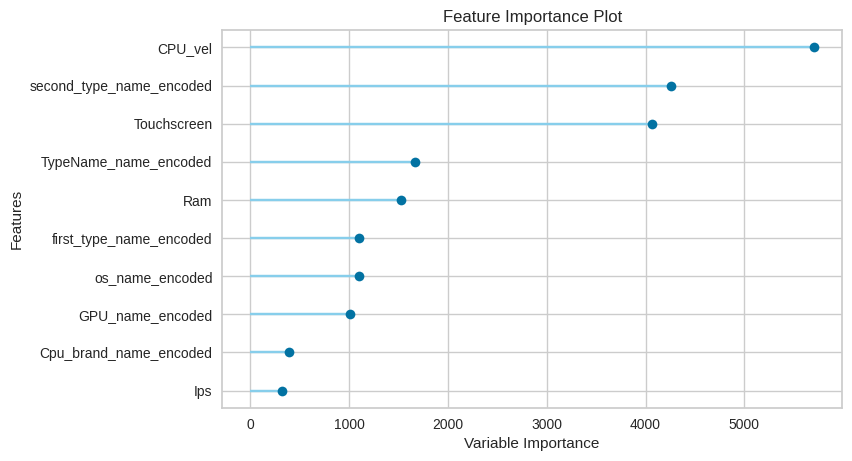

In [ ]:
# Plot of Feature Importance
plot_model(lr2, plot='feature')

In [ ]:
# print out the LRmodel,  線性回歸模型

print("Liner regression model:\nPrice = ")
for i in range(len(lr2.feature_names_in_)):
      print('\t',lr2.coef_[i]," ∘ ",lr2.feature_names_in_[i])

Liner regression model:
Price = 
	 152.98324552273266  ∘  Company_name_encoded
	 1665.4064560469376  ∘  TypeName_name_encoded
	 393.81890970633583  ∘  Cpu_brand_name_encoded
	 5704.568302853914  ∘  CPU_vel
	 1012.8332928801666  ∘  GPU_name_encoded
	 1523.9263917652856  ∘  Ram
	 1101.4586056257183  ∘  first_type_name_encoded
	 -2.5293534633401578  ∘  first_size
	 -4256.921099641568  ∘  second_type_name_encoded
	 -6.14630762640752  ∘  second_size
	 4063.909981055675  ∘  Touchscreen
	 321.3693913361701  ∘  Ips
	 116.22926770482869  ∘  Inches
	 76.24903326669977  ∘  ppi
	 1099.3172808286345  ∘  os_name_encoded


Note
---
1. What is the most important feature is? Why? 
2. There is no significant  differce between GPU_Nvidia and GPU_Intel, surprised?
3. From the copmare_models, the best one model is `catboost`. Try to make a model by `catboost` scheme.

In [ ]:

cat_model=create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3279.0469,22448252.6858,4737.9587,0.8697,0.2094,0.1749
1,4064.1858,40694492.5796,6379.2235,0.8154,0.2318,0.1828
2,3097.8421,20096928.4714,4482.9598,0.9045,0.1672,0.1323
3,4442.5211,55118182.6363,7424.1621,0.8145,0.2156,0.1709
4,4425.8531,47765095.9274,6911.2297,0.7126,0.2498,0.2002
5,3495.5852,24713932.8294,4971.3110,0.8594,0.1782,0.1475
6,3271.7718,24590855.9322,4958.9168,0.9103,0.2061,0.1513
7,3994.2534,39046036.8255,6248.6828,0.8156,0.2039,0.1560
8,4212.2707,35147817.2081,5928.5595,0.8259,0.1889,0.1519


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
pred_cat = predict_model(cat_model)
pred_cat

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,3852.4372,33727816.9314,5807.5655,0.8147,0.2231,0.1749


,Company_name_encoded,TypeName_name_encoded,Cpu_brand_name_encoded,CPU_vel,GPU_name_encoded,Ram,first_type_name_encoded,first_size,second_type_name_encoded,second_size,Touchscreen,Ips,Inches,ppi,os_name_encoded,Price,prediction_label
912,4.0,1.0,26.0,2.8,3.0,16.0,3.0,128.0,0.0,1000.0,0.0,0.0,15.600000,141.212006,2.0,28000,39603.972222
913,0.0,0.0,25.0,2.3,2.0,8.0,3.0,256.0,2.0,0.0,1.0,1.0,13.300000,165.632111,2.0,14300,19082.653041
914,7.0,3.0,24.0,2.4,2.0,4.0,3.0,256.0,2.0,0.0,0.0,0.0,15.600000,100.454666,2.0,15900,13371.609360
915,2.0,3.0,27.0,1.1,2.0,8.0,3.0,128.0,2.0,0.0,0.0,0.0,15.600000,141.212006,2.0,12000,15210.854570
916,10.0,3.0,26.0,2.5,3.0,8.0,1.0,0.0,2.0,0.0,0.0,0.0,15.600000,100.454666,1.0,13000,12561.159885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,10.0,0.0,25.0,2.3,2.0,4.0,3.0,128.0,2.0,0.0,1.0,0.0,14.000000,157.350510,2.0,17300,21228.648477
1299,7.0,3.0,26.0,1.8,3.0,8.0,1.0,1000.0,2.0,0.0,0.0,0.0,17.299999,127.335678,2.0,21100,17114.401650
1300,7.0,3.0,26.0,2.7,3.0,8.0,3.0,256.0,2.0,0.0,0.0,0.0,17.299999,127.335678,2.0,24900,28938.551835
1301,4.0,2.0,27.0,1.6,2.0,4.0,0.0,16.0,2.0,0.0,0.0,0.0,11.600000,135.094208,1.0,6100,6664.557111


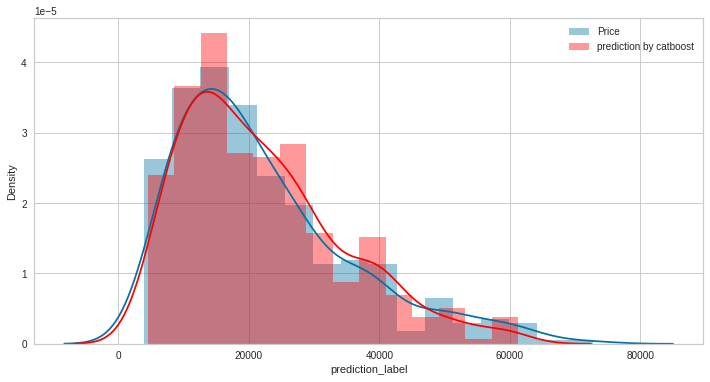

In [ ]:
plt.figure(figsize=[12,6])
sns.distplot(pred_cat['Price'],label='Price')
sns.distplot(pred_cat['prediction_label'],color='red',label='prediction by catboost')
plt.legend()

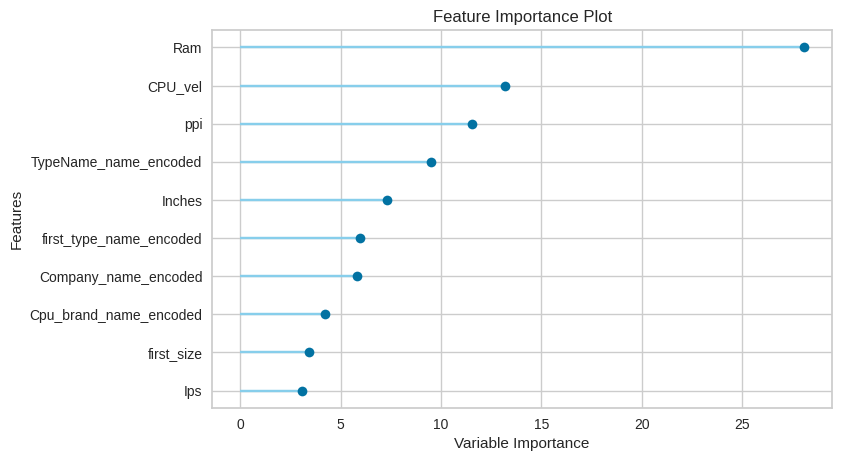

In [ ]:
# Plot of Feature Importance
plot_model(cat_model, plot='feature')

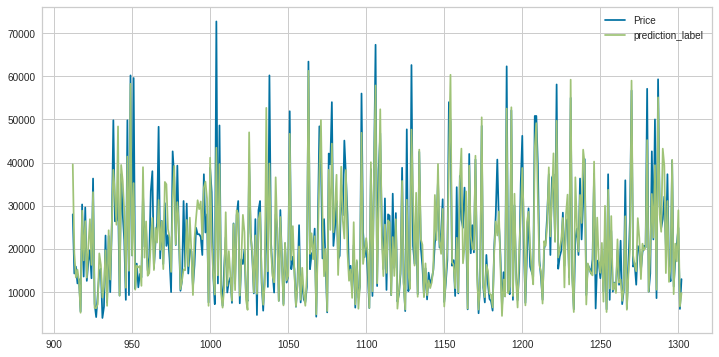

In [ ]:
pred_cat[['Price','prediction_label']].plot(figsize=[12,6])

In [ ]:
final_cat = finalize_model(cat_model)
save_model(final_cat, 'deloyment_xxx')

<font color="red">Note</font>
---
If no idea about what `graphviz` is, do not try to visualize the tree structure as follows, just use its prediction only! I don't know how to install graphviz in google drive too. 

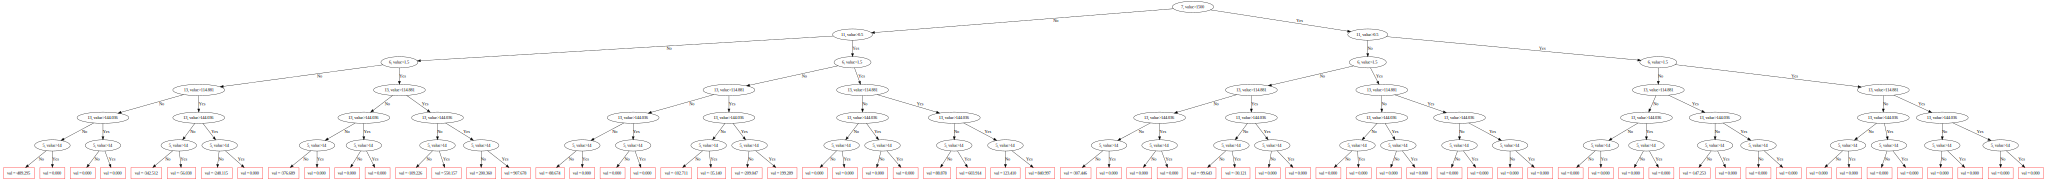

In [ ]:
cat_model.plot_tree(tree_idx=0)

Self-learning
---
1. Conclude the the result of cat_model above.
2. Conclude the skills leaned in the lecture this week.

Some notes about this Project
---
1. There are nighteen features used to build model. From the vis of Important Features, it is obvious that the relation between each feature and price is different. And the another issue: Are all the features necessary? No redundant ones among them? Or is there any feature which could confuse the model decision?

Answer: There are some tools/packages in ML developed for wise selection the features in model building. One is `featurewiz`, introduced here. 

In [ ]:
!pip install featurewiz


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 111 kB 33.6 MB/s 
     |████████████████████████████████| 3.2 MB 51.8 MB/s 
     |████████████████████████████████| 96 kB 6.2 MB/s 
     |████████████████████████████████| 26.7 MB 1.4 MB/s 
     |████████████████████████████████| 2.0 MB 39.0 MB/s 
     |████████████████████████████████| 1.6 MB 68.7 MB/s 
     |████████████████████████████████| 120 kB 66.3 MB/s 
     |████████████████████████████████| 82 kB 866 kB/s 
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 6.0.1
    Uninstalling pyarrow-6.0.1:
      Successfully uninstalled pyarrow-6.0.1
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pi

In [ ]:

### in Google drive
# !pip install Pillow==9.0.0
# !pip install xlrd — ignore-installed — no-deps

#import featurewiz as gwiz
from featurewiz import featurewiz


Imported 0.2.02 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']



In [ ]:
wiz =gwiz.FeatureWiz(verbose=1)

wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.30, random_state=42)

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
Correlation Limit = 0.7
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Regression problem ####
    Loaded train data. Shape = (1303, 19)
#### Single_Label Regression problem ####
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
        No variables were removed since no ID o

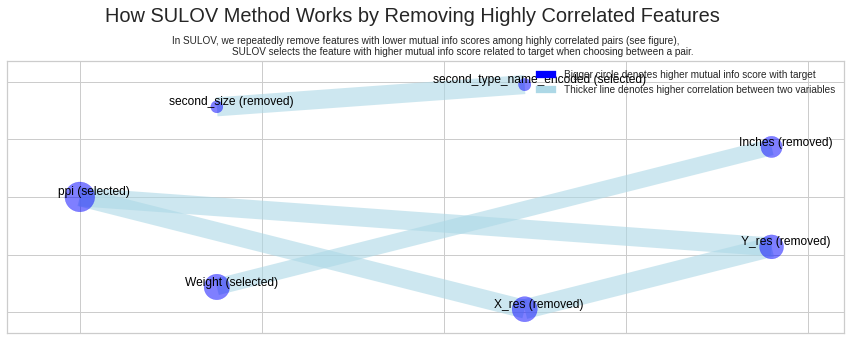

Time taken for SULOV method = 0 seconds
    Adding 0 categorical variables to reduced numeric variables  of 14
Final list of selected 14 vars after SULOV = ['CPU_vel', 'Company_name_encoded', 'Cpu_brand_name_encoded', 'GPU_name_encoded', 'Ips', 'Ram', 'Touchscreen', 'TypeName_name_encoded', 'first_size', 'first_type_name_encoded', 'os_name_encoded', 'ppi', 'Weight', 'second_type_name_encoded']
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 14 
    Taking top 4 features per iteration...
    XGBoost version using 1.6.2 as tree method: gpu_hist
Number of booster rounds = 100
        using 14 variables...
Regular XGBoost is crashing 

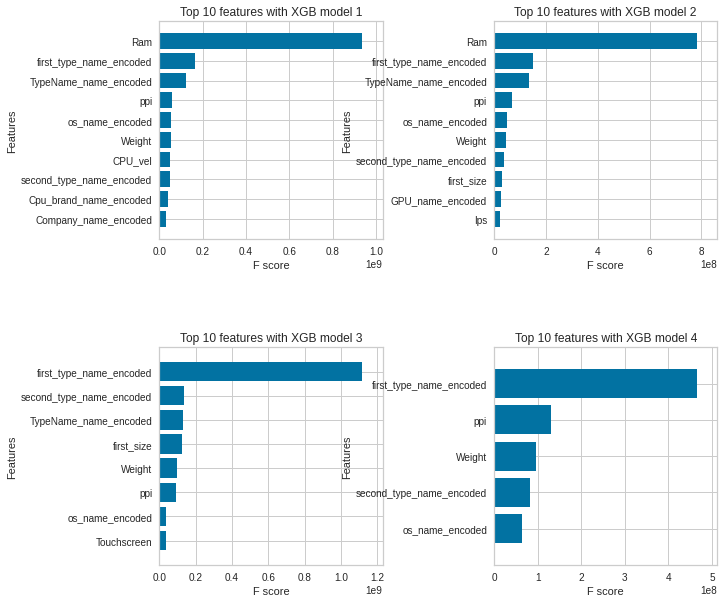

    Completed XGBoost feature selection in 1 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 9 important features:
['Ram', 'first_type_name_encoded', 'TypeName_name_encoded', 'ppi', 'os_name_encoded', 'Weight', 'CPU_vel', 'second_type_name_encoded', 'first_size']
Total Time taken for featurewiz selection = 3 seconds
Output contains a list of 9 important features and a train dataframe


In [ ]:
data=df[num_features+cat_features+target]

features = featurewiz(data, target, corr_limit=0.70,verbose=2)

In [ ]:
target

['Price']

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
Correlation Limit = 0.9
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Regression problem ####
    Loaded train data. Shape = (912, 19)
#### Single_Label Regression problem ####
loading the entire test dataframe - there is no nrows limit applicable #########
    Loaded test data. Shape = (391, 19)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
##############################################

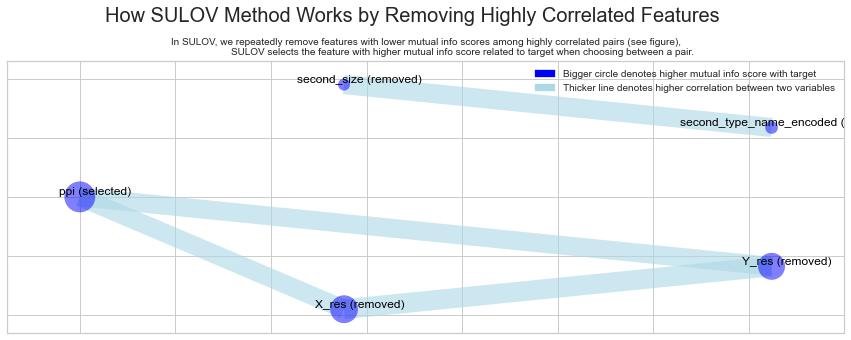

Time taken for SULOV method = 0 seconds
    Adding 0 categorical variables to reduced numeric variables  of 15
Final list of selected 15 vars after SULOV = ['CPU_vel', 'Company_name_encoded', 'Cpu_brand_name_encoded', 'GPU_name_encoded', 'Inches', 'Ips', 'Ram', 'Touchscreen', 'TypeName_name_encoded', 'Weight', 'first_size', 'first_type_name_encoded', 'os_name_encoded', 'ppi', 'second_type_name_encoded']
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 15 
    Taking top 4 features per iteration...
    XGBoost version using 1.6.2 as tree method: hist
Number of booster rounds = 100
        using 15 variables...
            selecting 

In [ ]:
trainm, testm = featurewiz(train, target,  test_data=test, verbose=1)# corr_limit=0.90, 


In [ ]:
feats = testm.columns.tolist()
print(feats)

['Ram', 'first_type_name_encoded', 'TypeName_name_encoded', 'ppi', 'Inches', 'CPU_vel', 'Weight', 'Touchscreen', 'first_size']


Note
---
Though there are 19 features considered in model building in pycaret test, featurewiz suggests that there might be only a little difference between  using 9 features and all 19's.

LazyPredict
---
Another similar project, build more than 40 models only in few lines! 

In [ ]:
import xgboost as xgb
xgb.__version__

'1.6.2'

In [ ]:
!pip install lazypredict

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
X=df[num_features+cat_features]
y=df[target].apply(lambda x: np.log1p(x))

X, y = shuffle(X,y, random_state=42)

#offset = int(X.shape[0] * 0.7)

#X_train, y_train = X[:offset], y[:offset]
#X_test, y_test = X[offset:], y[offset:]

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y.values[:,0],test_size=0.3)


In [ ]:
import lazypredict

from lazypredict.Supervised import LazyRegressor


In [ ]:
#reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None,predictions=True)
reg = LazyRegressor(verbose=0, ignore_warnings=True, predictions=True)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

In [ ]:
models

In [ ]:
predictions

In [ ]:
pred_df=pd.DataFrame()

In [ ]:
pred_df['Xgboost']=predictions['XGBRegressor'].apply(lambda x:np.expm1(x))
pred_df['Price']=np.expm1(y_test)

In [ ]:
plt.figure(figsize=[12,6])
sns.distplot(pred_df['Price'],label='Price')
sns.distplot(pred_df['Xgboost'],color='red',label='prediction by Xgboost')
plt.legend()

Note
---
1. only for test
2. no model deployment
3. no exact trained model information, parameters etc.

Feature Selection
---

In [ ]:
X=df[num_features+cat_features]
y=df[target].apply(lambda x: np.log1p(x))

X, y = shuffle(X,y, random_state=42)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42,test_size=0.3) 

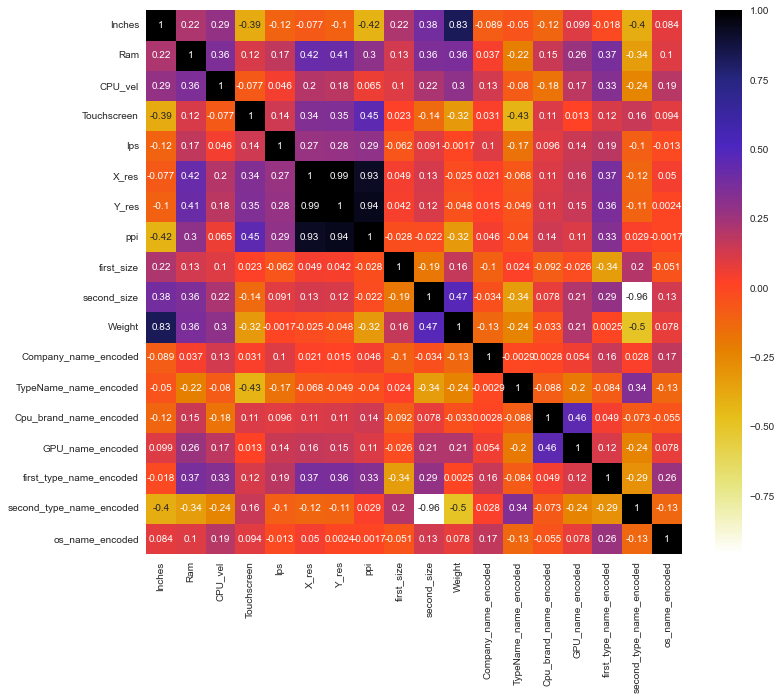

In [ ]:
# Pearson Correlation
cor = X_train.corr()
plt.figure(figsize=(12,10))
sns.heatmap(cor, cmap=plt.cm.CMRmap_r,annot=True);

In [ ]:
def correlation(dataset, threshold):
    col_corr = set()  
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: colname = corr_matrix.columns[i]                  
    col_corr.add(colname)
    return col_corr 

In [ ]:
corr_features = correlation(X_train, 0.85)
corr_features

{'second_type_name_encoded'}

In [ ]:
# Removing correlated features
X_train.drop(corr_features,axis=1)
X_test.drop(corr_features,axis=1)
#X_train     

,Inches,Ram,CPU_vel,Touchscreen,Ips,X_res,Y_res,ppi,first_size,second_size,Weight,Company_name_encoded,TypeName_name_encoded,Cpu_brand_name_encoded,GPU_name_encoded,first_type_name_encoded,os_name_encoded
2,15.6,8,2.5,0,0,1920,1080,141.211998,256,0,1.86,7,3,25,2,3,1
942,15.6,4,2.5,0,0,1366,768,100.454670,0,0,2.23,0,3,25,2,1,2
1122,14.0,8,2.3,0,0,1920,1080,157.350512,256,0,1.43,7,3,25,2,3,2
831,14.0,16,2.6,0,1,2560,1440,209.800683,512,0,1.10,10,4,26,2,3,2
875,12.5,8,2.8,0,0,1920,1080,176.232574,256,0,1.60,4,4,26,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,11.6,4,1.6,0,0,1366,768,135.094211,32,0,1.40,0,2,27,2,0,2
25,15.6,4,2.0,0,0,1366,768,100.454670,1000,0,2.30,4,3,24,2,1,2
1131,14.0,8,2.6,1,1,1920,1080,157.350512,512,0,1.80,10,0,26,3,3,2
930,15.6,4,1.1,0,0,1366,768,100.454670,1000,0,2.20,10,3,27,2,1,2


In [ ]:
data.to_csv("fastapi/Laptop_price_EDA_1.csv",index=0)

Deployment
---

In [ ]:
data.columns

Index(['Company_name_encoded', 'TypeName_name_encoded',
       'Cpu_brand_name_encoded', 'CPU_vel', 'GPU_name_encoded', 'Ram',
       'first_type_name_encoded', 'first_size', 'second_type_name_encoded',
       'second_size', 'Touchscreen', 'Ips', 'Inches', 'ppi', 'os_name_encoded',
       'Price'],
      dtype='object')

In [ ]:
final_cat = finalize_model(cat_model)

In [ ]:
# save transformation pipeline and model 
save_model(final_cat, 'fastapi/deployment_20221101_1')

Transformation Pipeline and Model Successfully Saved


(<catboost.core.CatBoostRegressor at 0x7fa783330c40>,
 'fastapi/deployment_20221101_1.pkl')

In [ ]:
df_dep=df.copy()


In [ ]:
df_dep.head(2)

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,...,Y_res,ppi,os,Company_name_encoded,TypeName_name_encoded,Cpu_brand_name_encoded,GPU_name_encoded,first_type_name_encoded,second_type_name_encoded,os_name_encoded
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128 SSD,Intel Iris Plus Graphics 640,macOS,1.37,...,1600,226.983005,Mac,1,4,25,2,3,2,0
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128 Flash Storage,Intel HD Graphics 6000,macOS,1.34,...,900,127.677940,Mac,1,4,25,2,0,2,0


In [ ]:
df_dep[['Company','Company_name_encoded']]

,Company,Company_name_encoded
0,Apple,1
1,Apple,1
2,HP,7
3,Apple,1
4,Apple,1
...,...,...
1298,Lenovo,10
1299,Lenovo,10
1300,Lenovo,10
1301,HP,7


In [ ]:
df_dep['Company_name_encoded'].unique()

array([ 1,  7,  0,  2,  4, 10,  3, 11, 13, 16,  8, 18, 17, 14, 12, 15,  6,
        5,  9])

In [ ]:
df_dep['Company'].unique()

array(['Apple', 'HP', 'Acer', 'Asus', 'Dell', 'Lenovo', 'Chuwi', 'MSI',
       'Microsoft', 'Toshiba', 'Huawei', 'Xiaomi', 'Vero', 'Razer',
       'Mediacom', 'Samsung', 'Google', 'Fujitsu', 'LG'], dtype=object)

In [ ]:
def label_dict(df_,feature,label_='_name_encoded'):
    feature_lab=feature+label_
    return {k: v for k, v in zip(df_[feature].unique(), df_[feature_lab].unique() )}

In [ ]:
label_dict(df_dep,'Company')

{'Apple': 1,
 'HP': 7,
 'Acer': 0,
 'Asus': 2,
 'Dell': 4,
 'Lenovo': 10,
 'Chuwi': 3,
 'MSI': 11,
 'Microsoft': 13,
 'Toshiba': 16,
 'Huawei': 8,
 'Xiaomi': 18,
 'Vero': 17,
 'Razer': 14,
 'Mediacom': 12,
 'Samsung': 15,
 'Google': 6,
 'Fujitsu': 5,
 'LG': 9}

In [ ]:
cat_f=['Company', 'TypeName','Cpu_brand', 'GPU', 'first_type', 'second_type','os']

label_array=[]
for cat in cat_f:
    #cat_=cat+'_dic'
    cat_=label_dict(df_dep,cat) 
    label_array.append(cat_)

In [ ]:
df_lab=pd.DataFrame(index=cat_f)
df_lab['label']=label_array

In [ ]:
df_lab

,label
Company,"{'Apple': 1, 'HP': 7, 'Acer': 0, 'Asus': 2, 'Dell': 4, 'Lenovo': 10, 'Chuwi': 3, 'MSI': 11, 'Microsoft': 13, 'Toshiba': 16, 'Huawei': 8, 'Xiaomi': 18, 'Vero': 17, 'Razer': 14, 'Mediacom': 12, 'Samsung': 15, 'Google': 6, 'Fujitsu': 5, 'LG': 9}"
TypeName,"{'Ultrabook': 4, 'Notebook': 3, 'Netbook': 2, 'Gaming': 1, '2 in 1 Convertible': 0, 'Workstation': 5}"
Cpu_brand,"{'Intel Core i5': 25, 'Intel Core i7': 26, 'AMD A9-Series 9420': 11, 'Intel Core i3': 24, 'Other Intel Processor': 27, 'AMD E-Series E2-9000e': 19, 'AMD E-Series E2-6110': 17, 'AMD A6-Series 9220': 7, 'AMD Ryzen 1700': 23, 'AMD FX 9830P': 21, 'AMD E-Series 6110': 13, 'AMD E-Series 9000e': 16, 'AMD A10-Series A10-9620P': 2, 'AMD A6-Series A6-9220': 8, 'AMD A10-Series 9600P': 0, 'AMD A8-Series 7410': 9, 'AMD A12-Series 9720P': 4, 'AMD Ryzen 1600': 22, 'AMD A10-Series 9620P': 1, 'AMD E-Series 7110': 14, 'AMD A9-Series A9-9420': 12, 'AMD E-Series E2-9000': 18, 'AMD A6-Series 7310': 6, 'AMD A12-Series 9700P': 3, 'AMD A4-Series 7210': 5, 'AMD FX 8800P': 20, 'Others Processor': 28, 'AMD E-Series 9000': 15, 'AMD A9-Series 9410': 10}"
GPU,"{'Intel': 2, 'AMD': 0, 'Nvidia': 3, 'ARM': 1}"
first_type,"{'SSD': 3, 'Flash': 0, 'HDD': 1, 'Hybrid': 2}"
second_type,"{'None': 2, 'HDD': 0, 'SSD': 3, 'Hybrid': 1}"
os,"{'Mac': 0, 'Others/No OS/Linux': 1, 'Windows': 2}"


In [ ]:
oss=df_lab.loc[df_lab.index=='os','label'][0]

In [ ]:
feature_opt=list(df_lab.index)
feature_opt

['Company', 'TypeName', 'Cpu_brand', 'GPU', 'first_type', 'second_type', 'os']

In [ ]:

def select_type(opt,feature_opt):
    dic_=df_lab.loc[df_lab.index==feature_opt,'label'][0]
    #print(feature_opt, opt," : value ",dic_[opt])
    return dic_[opt]
    

In [ ]:
select_type('Microsoft','Company')

13

In [ ]:
df['Ram'].unique()

array([ 8, 16,  4,  2, 12,  6, 32, 24, 64], dtype=int32)

In [ ]:
num_features+cat_features

['Inches',
 'Ram',
 'CPU_vel',
 'Touchscreen',
 'Ips',
 'X_res',
 'Y_res',
 'ppi',
 'first_size',
 'second_size',
 'Weight',
 'Company_name_encoded',
 'TypeName_name_encoded',
 'Cpu_brand_name_encoded',
 'GPU_name_encoded',
 'first_type_name_encoded',
 'second_type_name_encoded',
 'os_name_encoded']

In [ ]:
df['Weight'].describe()

count    1303.000000
mean        2.038734
std         0.665475
min         0.690000
25%         1.500000
50%         2.040000
75%         2.300000
max         4.700000
Name: Weight, dtype: float64

In [ ]:
import joblib

In [ ]:
model_pkl = joblib.load('fastapi/deployment_20221031.pkl')

In [ ]:
model_pkl

Pipeline(memory=Memory(location=/var/folders/xb/s7vwrt4153xbxzr8hc8tbdtr0000gn/T/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['Inches', 'Ram', 'CPU_vel',
                                             'Touchscreen', 'Ips', 'X_res',
                                             'Y_res', 'ppi', 'first_size',
                                             'second_size', 'Weight',
                                             'Company_name_encoded',
                                             'TypeName_name_encoded',
                                             'Cpu_brand_name_encoded',
                                             'GPU_name_encoded',
                                             'first_type...
                                             'second_type_name_encoded',
                                             'os_name_encoded'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(fill_value='constant',
                                                              strategy='constant'))),
                ('low_variance',
                 TransformerWrapper(exclude=[],
                                    transformer=VarianceThreshold(threshold=0))),
                ('trained_model',
                 <catboost.core.CatBoostRegressor object at 0x7fc1f3d54700>)])

In [ ]:
l=[1,2,3,4,5]
l1=np.array(l).reshape(1, -1)

In [ ]:
np.shape(l)

(5,)

Deplyment
---
- [link](https://medium.com/@goradbj/how-to-build-complete-end-to-end-ml-model-backend-restapi-using-fastapi-and-front-end-ui-using-22f64bf04476)
-[link](https://github.com/mathangpeddi/Laptop-Prices-Predictor/blob/master/Laptop_Prices_Prediction.ipynb)

After model building, the final work is to deploy the model for (web)-service. 
```

Front-end UI. <----> Deployment <----> Model

```
Here, we introduce the Streamlit package to deploy the application, including UI and web app itself.

1. Create the following file, `app.py`, in certain sub-folder:

```python
### app.py
# required packages

import streamlit as st
import joblib

# load model pkl for prediction
model = joblib.load('deployment_20221031.pkl')

# Web Page title
st.title('Laptop Prices Predictor')

# selection input
Company = st.selectbox("Company", options=df["Company"].unique())
Company_of_laptop = select_type(Company,'Company')

# numerical input 
ram_in_gb = st.number_input('RAM in GB', step=4, min_value=4)

# radio input
touchscreen  = st.radio("Touchscreen (0-No,1-Yes)", options=[0, 1])
...

features=[Company_of_laptop, ram_in_gb, touchscreen, ...]
final_features = np.array(features).reshape(1, -1)

if st.button('Predict'):
    prediction = model.predict(final_features)
    st.balloons()
    st.success(f'Predicted Price of the Laptop is about NT$ {prediction[0]}')
```

And startup the service by follows:

 > streamlit run app.py


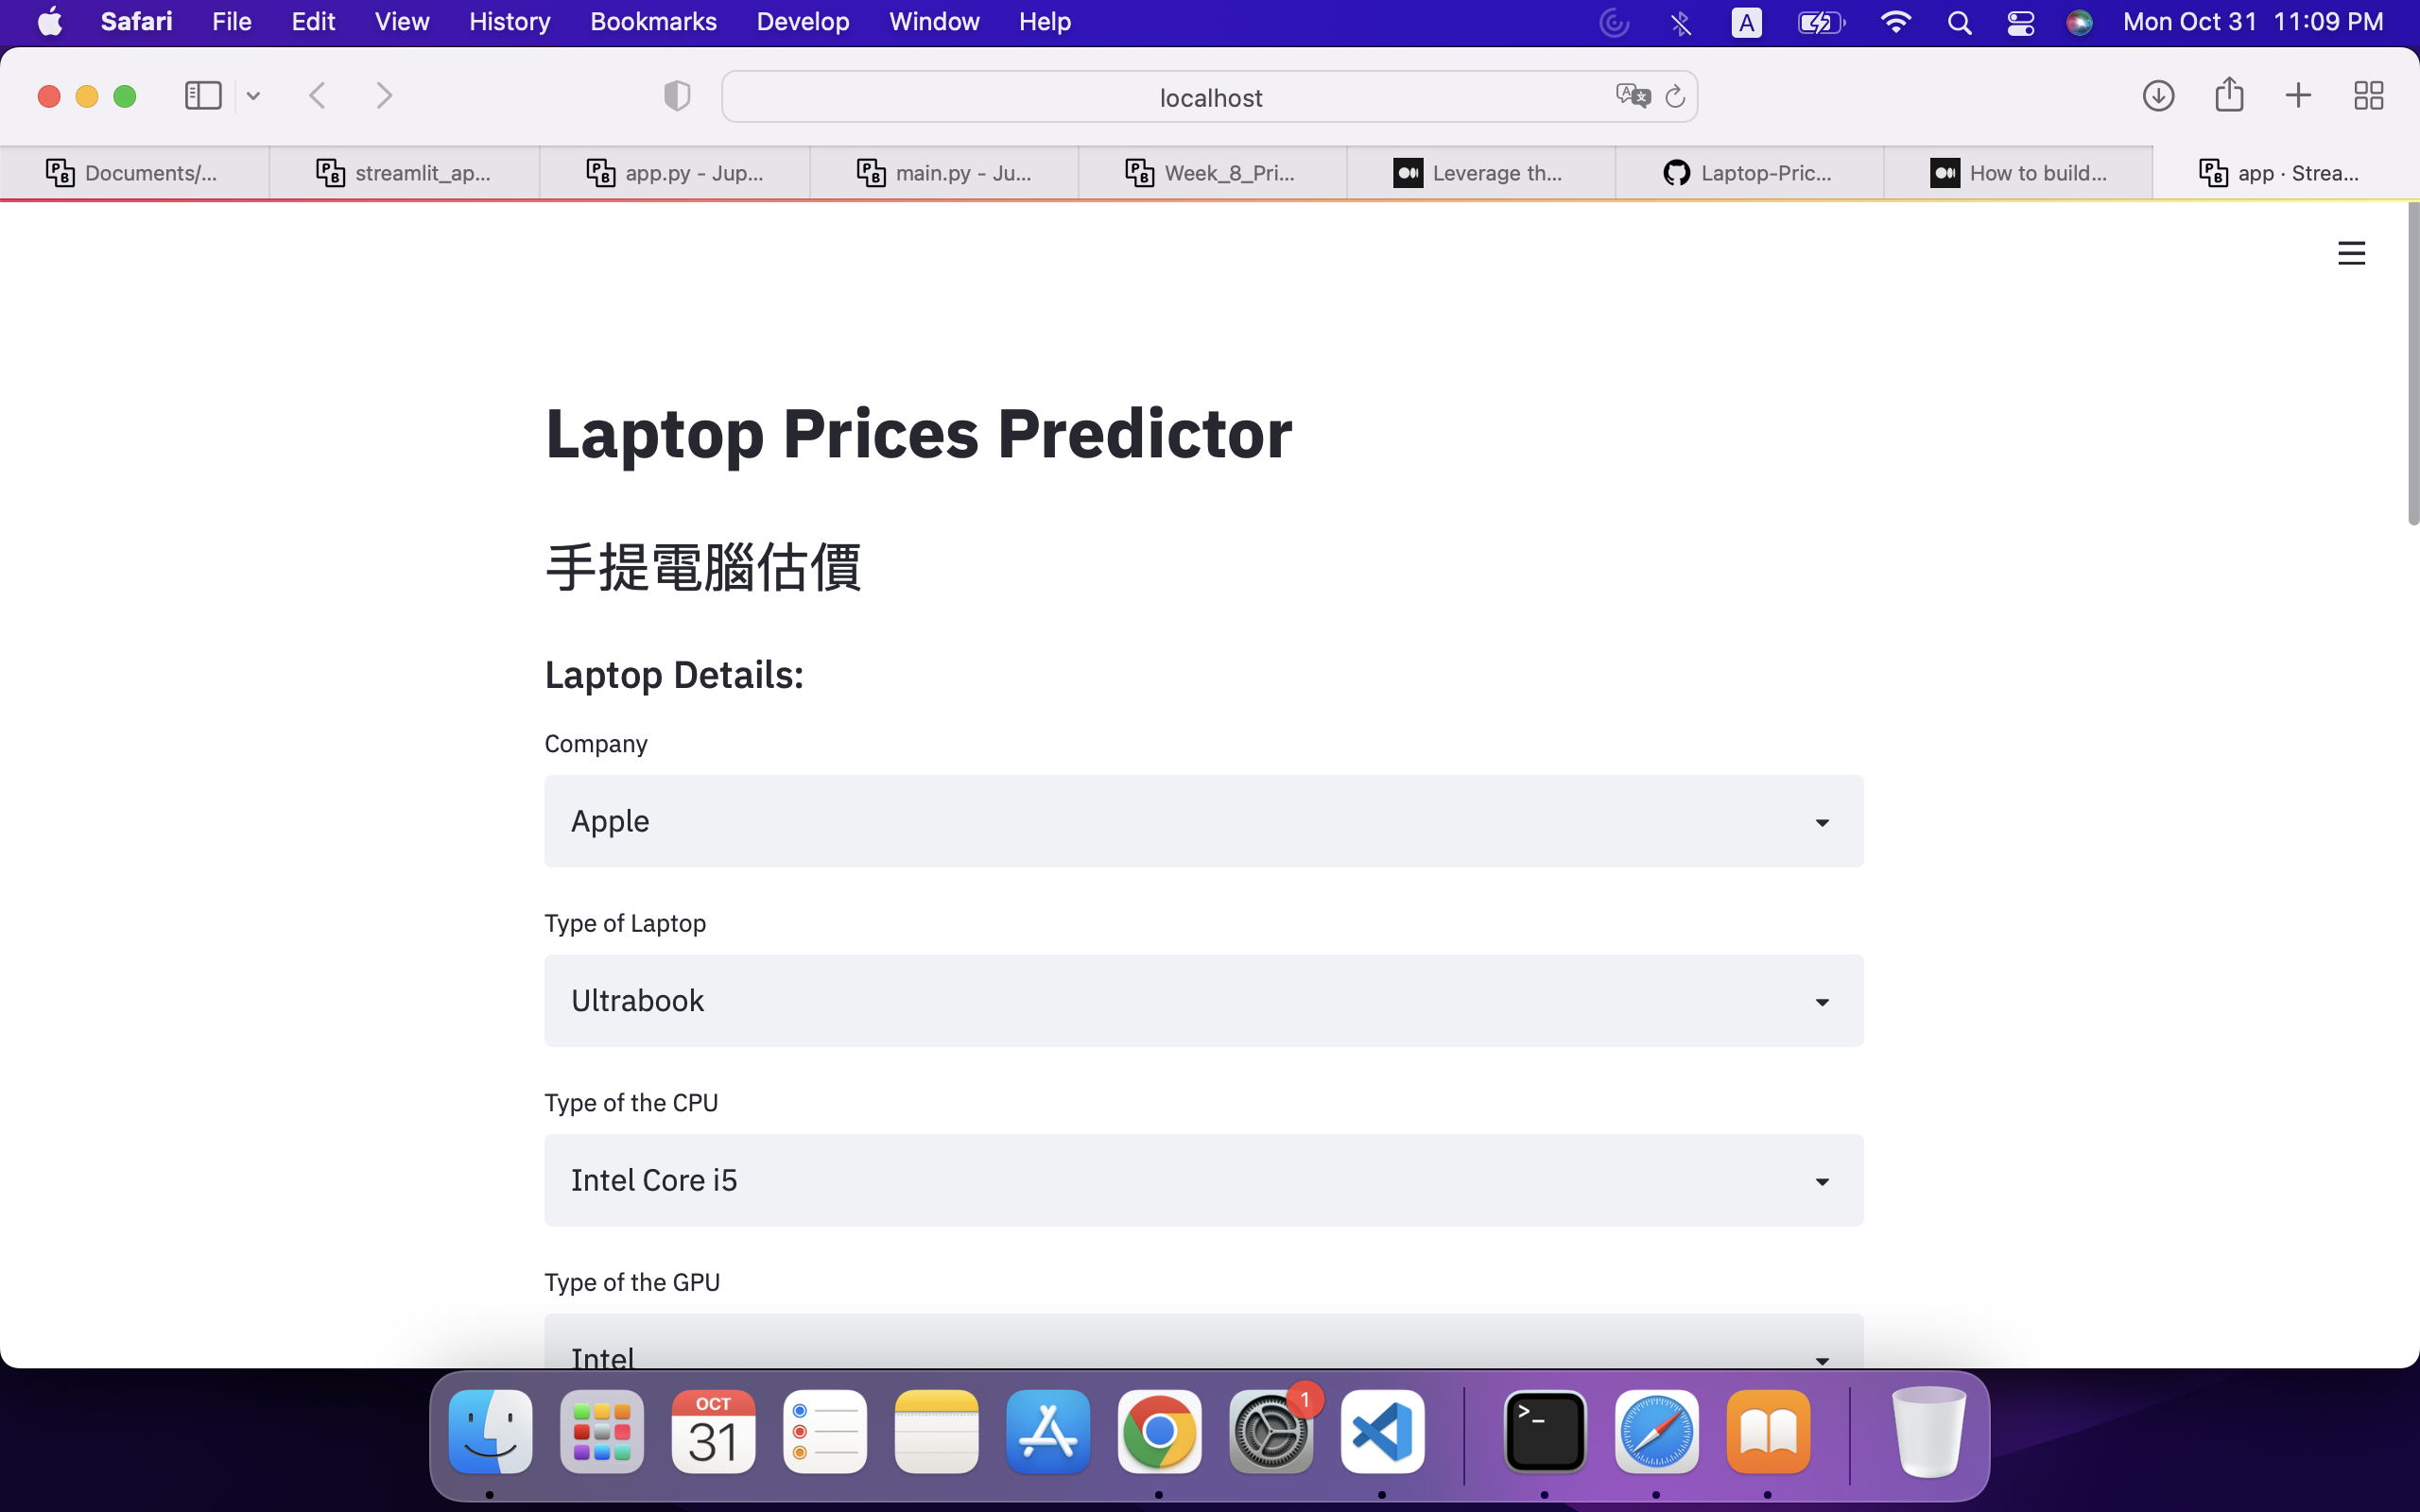

In [ ]:
from IPython.display import Image
Image("laptop.png")

In [ ]:
df_pkl=pd.read_pickle("fastapi/deployment_20221101.pkl")

In [ ]:
df_pkl

array(['Company_name_encoded', 'TypeName_name_encoded',
       'Cpu_brand_name_encoded', 'CPU_vel', 'GPU_name_encoded', 'Ram',
       'first_type_name_encoded', 'first_size',
       'second_type_name_encoded', 'second_size', 'Touchscreen', 'Ips',
       'Inches', 'ppi', 'os_name_encoded'], dtype=object)

In [ ]:
import joblib
model_pkl = load_model('fastapi/deployment_20221101_1')

Transformation Pipeline and Model Successfully Loaded


In [ ]:
l=[[ 1., 4., 25., 1., 2., 4., 3., 32., 2., 0., 0., 0., 10., 90., 0.]]

In [ ]:
model_pkl.predict(l)

array([17339.82074442])

In [ ]:
pd.__version__

'1.5.1'

In [ ]:
data.head()

,Company_name_encoded,TypeName_name_encoded,Cpu_brand_name_encoded,CPU_vel,GPU_name_encoded,Ram,first_type_name_encoded,first_size,second_type_name_encoded,second_size,Touchscreen,Ips,Inches,ppi,os_name_encoded,Price
0,1,4,25,2.3,2,8,3,128,2,0,0,1,13.3,226.983005,0,27800
1,1,4,25,1.8,2,8,0,128,2,0,0,0,13.3,127.677940,0,18600
2,7,3,25,2.5,2,8,3,256,2,0,0,0,15.6,141.211998,1,11900
3,1,4,26,2.7,0,16,3,512,2,0,0,1,15.4,220.534624,0,52700
4,1,4,25,3.1,2,8,3,256,2,0,0,1,13.3,226.983005,0,37400
